In [1]:
# Import packages and set universal parameters

#%matplotlib notebook
import pandas as pd
import numpy as np
from numpy.linalg import eig
import csv
import pylab as pl
import matplotlib.pyplot as plt
import copy
import scipy as stats
from scipy import stats
from scipy.stats import linregress
from scipy.stats import t
from scipy.stats import chi2
from scipy.stats import sem
from scipy.linalg import hadamard
from scipy.stats import ttest_ind_from_stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind_from_stats
from sklearn.manifold import TSNE
from collections import OrderedDict 
#import seaborn as sns
#sns.set()
import sklearn
from sklearn.neighbors import *
import time
from random import random
from random import randint
from random import randrange
from matplotlib.lines import Line2D
from textwrap import wrap
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import statistics
import seaborn as sns
import matplotlib.colors as mcolors
import imageio
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.preprocessing import MinMaxScaler
from PIL import Image

# Say, "the default sans-serif font is Arial"
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
# Set conditions for legend
plt.rcParams['legend.title_fontsize'] = 7

## Import cleaned data in proper format

In [ ]:
# Introduce the keys for barcode mapping, demultiplexing as dataframes
# First, mapping from inline index to epoch, and defining some other lists for later
# Here "Epoch" refers to the generation of the evolution experiment from which populations were sampled in the bulk fitness assay (BFA)
epochind = {'Epoch': ['0','200','400','600','800','1000'],
           'Inline': ['GGTATCA','GATGTCCT','CTCATCCAG','GACGGAACTC','ATCGCAGGCAT','TCACGACTAGTA']}
epochind = pd.DataFrame(epochind)

epochshort = ['0','2','4','6','8','10']

ploidies = ['H','D']
envts = ['30','AA','37','RT','NaCl']
reps = ['1','2']
mytimepoints = ['tp1','tp3','tp5']

# Note: YPD with 10% as much peptone was tried as an evolution environment originally,
# but it was discontinued due to growth issues. Ancestors of these populations were
# used as references in BFAs.

evoenvs = ['YPD','YPD+AA','YPD(37C)','YP10%D']
evoenvsno10 = ['YPD','YPD+AA','YPD(37C)']
evoenvs_simp = ['30','AA','37','YP10']
envts_abbrevofficial = ['YPD','Ac.ac.','37°C','21°C','NaCl']

# purge "unfiltered" counts files of all errant BCs (i.e., those with the wrong inline indices)
filenames_epoch = pd.read_csv("counts_filenames_take2_cat-forpipeline_v2.csv")

for countsfile in np.arange(len(filenames_epoch)):
    # define what the inline index *should* be
    myepochtest = epochind['Epoch'] == str(filenames_epoch['epochID'][countsfile])
    myepochind = epochind[myepochtest]
    relevant_inline = myepochind.iloc[:,1]
    relevant_inline = relevant_inline.iloc[0]
    
    # read in one of the counts files
    file1 = pd.read_csv("output1_take2_cat_regind_v2/counts/unfiltered/"+filenames_epoch['filename'][countsfile])
    
    # add a column for the inline indices
    inline_list = []
    for mybc in np.arange(len(file1)):
        myfind = file1['BC'][mybc].find("_")
        inline_list.append(file1['BC'][mybc][:myfind])
    file1['Inline'] = inline_list
    
    # filter for only those barcodes that have the right inline index
    inlinetest = file1['Inline'] == relevant_inline
    file1 = file1[inlinetest]
    
    # export to a new folder
    export_csv = file1.to_csv(r'output1_take2_cat_regind_v2/counts-decontam/decontam_'+filenames_epoch['filename'][countsfile],index=True,header=True)

    # read in LP2 version of the counts files
    file2 = pd.read_csv("output2_take2_cat_regind_v2/counts/unfiltered/"+filenames_epoch['filename'][countsfile])
    
    # add a column for the inline indices
    inline_list = []
    for mybc in np.arange(len(file2)):
        myfind = file2['BC'][mybc].find("_")
        inline_list.append(file2['BC'][mybc][:myfind])
    file2['Inline'] = inline_list
    
    # filter for only those barcodes that have the right inline index
    inlinetest = file2['Inline'] == relevant_inline
    file2 = file2[inlinetest]
    
    # export to a new folder
    export_csv = file2.to_csv(r'output2_take2_cat_regind_v2/counts-decontam/decontam_'+filenames_epoch['filename'][countsfile],index=True,header=True)
    
# make a new barcodelist

# import filenames
filenames = pd.read_csv("counts_filenames_take2_cat_v2.csv")

barcodes1 = pd.DataFrame()
barcodes2 = pd.DataFrame()
for countsfile in np.arange(len(filenames)):
    output1 = pd.read_csv("output1_take2_cat_regind_v2/counts-decontam/decontam_"+filenames['filename'][countsfile])
    output1 = output1[['BC','Reads']]
    barcodes1 = barcodes1.append(output1[['BC']])
    output2 = pd.read_csv("output2_take2_cat_regind_v2/counts-decontam/decontam_"+filenames['filename'][countsfile])
    output2 = output2[['BC','Reads']]
    barcodes2 = barcodes2.append(output2[['BC']])

barcodes1 = barcodes1.drop_duplicates()
barcodes1 = barcodes1.reset_index(drop = True)
barcodes2 = barcodes2.drop_duplicates()
barcodes2 = barcodes2.reset_index(drop = True)
barcodes_all = barcodes1.append(barcodes2)
barcodes_all = barcodes_all.drop_duplicates()
barcodes_all = barcodes_all.reset_index(drop = True)

# create a pandas dataframe that has all barcodes on the left and all read counts
# first do LP1
# read in the list of barcodes (expansive - larger than the actual set of barcodes)

d1 = barcodes1

# for each counts file, read in the info and join to the barcode list
for countsfile in np.arange(len(filenames)):
    d2 = pd.read_csv("output1_take2_cat_regind_v2/counts-decontam/decontam_"+filenames['filename'][countsfile])
    d2 = d2[['BC','Reads']]

    abbrev = filenames['filename'][countsfile]
    abbrev_end = abbrev.find('_S')
    abbrev = abbrev[:abbrev_end]

    d2 = d2.rename(index=str,columns={"Reads":abbrev+"Reads"})
    d1 = pd.merge(d1,d2,on='BC',how='outer')

# now do LP2

d3 = barcodes2

for countsfile in np.arange(len(filenames)):
    d4 = pd.read_csv("output2_take2_cat_regind_v2/counts-decontam/decontam_"+filenames['filename'][countsfile])
    d4 = d4[['BC','Reads']]

    abbrev = filenames['filename'][countsfile]
    abbrev_end = abbrev.find('_S')
    abbrev = abbrev[:abbrev_end]

    d4 = d4.rename(index=str,columns={"Reads":abbrev+"Reads"})
    d3 = pd.merge(d3,d4,on='BC',how='outer')

LP1_Readscounts = d1
LP2_Readscounts = d3

# for each row, put in a flag about whether it came from the LP1 or LP2 parsing
LP1_Readscounts['Parsing'] = "LP1_parsing"
LP2_Readscounts['Parsing'] = "LP2_parsing"

# append the two tables
Readscounts = LP1_Readscounts.append(LP2_Readscounts)
# and replace the old index for a new continuous one
Readscounts = Readscounts.reset_index(drop=True)

# parse the barcode for inline index and bc and add as columns to Readscounts
inline_list = []
bc_list = []
for mybc in np.arange(len(Readscounts)):
    myfind = Readscounts['BC'][mybc].find("_")
    inline_list.append(Readscounts['BC'][mybc][:myfind])
    bc_list.append(Readscounts['BC'][mybc][myfind+1:])

Readscounts['Inline'] = inline_list
Readscounts['popBC'] = bc_list

# merge with Readscounts
Readscounts = pd.merge(Readscounts,epochind,on='Inline',how='left')

# Second, mapping from barcode to all the salient variables, "demographic" info
bcmap = pd.read_csv('20190705_bcmap_v07.csv')
Readscounts = pd.merge(Readscounts,bcmap,on='popBC',how='left')

# clean up the table

# remove spurious columns
Readscounts = Readscounts.drop('plate_id',axis=1)
Readscounts = Readscounts.drop('row_id',axis=1)
Readscounts = Readscounts.drop('col_id',axis=1)

# want to clean up the data so there is no longer one column per epoch. Just one per tp_envt_rep.
# Approach: Create subtables for each epoch. Then rename to the epoch-generic titles. Then append.

ReadsnoE = Readscounts.copy(deep=True)

consReadscounts = pd.DataFrame()

for epoch in np.arange(len(epochshort)):
    mynew = ReadsnoE.loc[:,['BC','tp0_na-na_e'+epochshort[epoch]+'Reads','tp1_30-1_e'+epochshort[epoch]+'Reads','tp3_30-1_e'+epochshort[epoch]+'Reads','tp5_30-1_e'+epochshort[epoch]+'Reads','tp1_30-2_e'+epochshort[epoch]+'Reads','tp3_30-2_e'+epochshort[epoch]+'Reads','tp5_30-2_e'+epochshort[epoch]+'Reads','tp1_37-1_e'+epochshort[epoch]+'Reads','tp3_37-1_e'+epochshort[epoch]+'Reads','tp5_37-1_e'+epochshort[epoch]+'Reads','tp1_37-2_e'+epochshort[epoch]+'Reads','tp3_37-2_e'+epochshort[epoch]+'Reads','tp5_37-2_e'+epochshort[epoch]+'Reads','tp1_AA-1_e'+epochshort[epoch]+'Reads','tp3_AA-1_e'+epochshort[epoch]+'Reads','tp5_AA-1_e'+epochshort[epoch]+'Reads','tp1_AA-2_e'+epochshort[epoch]+'Reads','tp3_AA-2_e'+epochshort[epoch]+'Reads','tp5_AA-2_e'+epochshort[epoch]+'Reads','tp1_RT-1_e'+epochshort[epoch]+'Reads','tp3_RT-1_e'+epochshort[epoch]+'Reads','tp5_RT-1_e'+epochshort[epoch]+'Reads','tp1_RT-2_e'+epochshort[epoch]+'Reads','tp3_RT-2_e'+epochshort[epoch]+'Reads','tp5_RT-2_e'+epochshort[epoch]+'Reads','tp1_NaCl-1_e'+epochshort[epoch]+'Reads','tp3_NaCl-1_e'+epochshort[epoch]+'Reads','tp5_NaCl-1_e'+epochshort[epoch]+'Reads','tp1_NaCl-2_e'+epochshort[epoch]+'Reads','tp3_NaCl-2_e'+epochshort[epoch]+'Reads','tp5_NaCl-2_e'+epochshort[epoch]+'Reads','Parsing','Inline','popBC','Epoch','dip_bc','evocode','ploidy','evoEnvt','celltype','LP','BCs-in-pop']]
    mytest = mynew['Epoch'] == epochind['Epoch'][epoch]
    mynew2 = mynew[mytest]
    mynew2 = mynew2.rename(columns={'tp0_na-na_e'+epochshort[epoch]+'Reads':'tp0_na-na_Reads','tp1_30-1_e'+epochshort[epoch]+'Reads':'tp1_30-1_Reads','tp3_30-1_e'+epochshort[epoch]+'Reads':'tp3_30-1_Reads','tp5_30-1_e'+epochshort[epoch]+'Reads':'tp5_30-1_Reads','tp1_30-2_e'+epochshort[epoch]+'Reads':'tp1_30-2_Reads','tp3_30-2_e'+epochshort[epoch]+'Reads':'tp3_30-2_Reads','tp5_30-2_e'+epochshort[epoch]+'Reads':'tp5_30-2_Reads','tp1_37-1_e'+epochshort[epoch]+'Reads':'tp1_37-1_Reads','tp3_37-1_e'+epochshort[epoch]+'Reads':'tp3_37-1_Reads','tp5_37-1_e'+epochshort[epoch]+'Reads':'tp5_37-1_Reads','tp1_37-2_e'+epochshort[epoch]+'Reads':'tp1_37-2_Reads','tp3_37-2_e'+epochshort[epoch]+'Reads':'tp3_37-2_Reads','tp5_37-2_e'+epochshort[epoch]+'Reads':'tp5_37-2_Reads','tp1_AA-1_e'+epochshort[epoch]+'Reads':'tp1_AA-1_Reads','tp3_AA-1_e'+epochshort[epoch]+'Reads':'tp3_AA-1_Reads','tp5_AA-1_e'+epochshort[epoch]+'Reads':'tp5_AA-1_Reads','tp1_AA-2_e'+epochshort[epoch]+'Reads':'tp1_AA-2_Reads','tp3_AA-2_e'+epochshort[epoch]+'Reads':'tp3_AA-2_Reads','tp5_AA-2_e'+epochshort[epoch]+'Reads':'tp5_AA-2_Reads','tp1_RT-1_e'+epochshort[epoch]+'Reads':'tp1_RT-1_Reads','tp3_RT-1_e'+epochshort[epoch]+'Reads':'tp3_RT-1_Reads','tp5_RT-1_e'+epochshort[epoch]+'Reads':'tp5_RT-1_Reads','tp1_RT-2_e'+epochshort[epoch]+'Reads':'tp1_RT-2_Reads','tp3_RT-2_e'+epochshort[epoch]+'Reads':'tp3_RT-2_Reads','tp5_RT-2_e'+epochshort[epoch]+'Reads':'tp5_RT-2_Reads','tp1_NaCl-1_e'+epochshort[epoch]+'Reads':'tp1_NaCl-1_Reads','tp3_NaCl-1_e'+epochshort[epoch]+'Reads':'tp3_NaCl-1_Reads','tp5_NaCl-1_e'+epochshort[epoch]+'Reads':'tp5_NaCl-1_Reads','tp1_NaCl-2_e'+epochshort[epoch]+'Reads':'tp1_NaCl-2_Reads','tp3_NaCl-2_e'+epochshort[epoch]+'Reads':'tp3_NaCl-2_Reads','tp5_NaCl-2_e'+epochshort[epoch]+'Reads':'tp5_NaCl-2_Reads'})
    consReadscounts = consReadscounts.append(mynew2)

consReadscounts = consReadscounts.reset_index(drop=True)    

# But I want these data to be better and ready for s inference.
# To do that, want to sum the barcodes for a given population

# Add a column for evocode-epoch combinations
consReadscounts['evocode-Epoch'] = consReadscounts['evocode']+"-"+consReadscounts['Epoch'].map(str)

# Create a reference list containing all evocode-Epochs
eEs = consReadscounts['evocode-Epoch'].drop_duplicates()
# get rid of the nan values for the barcodes we don't have associated with pops yet!
eEs = eEs.dropna()

eEs = eEs.values.tolist()

# go through and sum up the barcodes for each evocode-Epoch
# create an empty dataframe that will serve as the ultimate repository
summedReads = pd.DataFrame()

for e in np.arange(len(eEs)):
    # create an empty DataFrame that will house the new row
    newrow = pd.DataFrame()
    # create subtable for a given evocode-Epoch
    mytest = consReadscounts['evocode-Epoch'] == eEs[e]
    mytesttoys1 = consReadscounts[mytest]
    # populate newrow with the qualitative info
    newrow['evocode-Epoch'] = mytesttoys1['evocode-Epoch']
    newrow['Parsing'] = mytesttoys1['Parsing']
    newrow['Epoch'] = mytesttoys1['Epoch']
    newrow['evocode'] = mytesttoys1['evocode']
    newrow['ploidy'] = mytesttoys1['ploidy']
    newrow['evoEnvt'] = mytesttoys1['evoEnvt']
    newrow['celltype'] = mytesttoys1['celltype']
    newrow['LP'] = mytesttoys1['LP']
    newrow['BCs-in-pop'] = mytesttoys1['BCs-in-pop']
    newrow = newrow.iloc[0,:]
    newrow = newrow.to_frame()
    newrow = newrow.transpose()
    
    # add sums of other fields
    for countsfile in np.arange(len(filenames)):
        abbrev = filenames['filename'][countsfile]
        abbrev_end = abbrev.find('_e')
        abbrev = abbrev[:abbrev_end]
        abbrev = abbrev+'_Reads'
        newrow[abbrev] = mytesttoys1[abbrev].sum()
    
    # append this new row to the summedReads dataframe
    summedReads = summedReads.append(newrow)


# add one set of rows specifically for those not assigned an evocode
newrow = pd.DataFrame()
# create subtable for a given evocode-Epoch
mytest = consReadscounts['evocode'].isnull()
mytesttoys1 = consReadscounts[mytest]
# populate newrow with the qualitative info
newrow['evocode-Epoch'] = mytesttoys1['evocode-Epoch']
newrow['evocode'] = mytesttoys1['evocode']
newrow['ploidy'] = mytesttoys1['ploidy']
newrow['evoEnvt'] = mytesttoys1['evoEnvt']
newrow['celltype'] = mytesttoys1['celltype']
newrow['LP'] = mytesttoys1['LP']
newrow['BCs-in-pop'] = mytesttoys1['BCs-in-pop']
newrow = newrow.iloc[0,:]
newrow = newrow.to_frame()
newrow = newrow.transpose()

# add sums of other fields
for countsfile in np.arange(len(filenames)):
    abbrev = filenames['filename'][countsfile]
    abbrev_end = abbrev.find('_e')
    abbrev = abbrev[:abbrev_end]
    abbrev = abbrev+'_Reads'
    newrow[abbrev] = mytesttoys1[abbrev].sum()

# append this new row to the summedReads dataframe
summedReads = summedReads.append(newrow)

#reset index
summedReads = summedReads.reset_index(drop=True)

## Estimate s

In [ ]:
# First, create new table for these calculations.
logtable = summedReads.copy(deep=True)

# Second, create and populate new fields with log frequencies
for ploidy in np.arange(0,2):
    for epoch in np.arange(len(epochind['Epoch'])):
        for LP in np.arange(1,3):
            for envt in np.arange(len(envts)):
                for rep in np.arange(len(reps)):
                    mytesttoys4 = logtable.loc[(logtable['ploidy'] == ploidies[ploidy])&(logtable['Epoch'] == epochind['Epoch'][epoch])&(logtable['LP'] == LP)].copy(deep=True).reset_index(drop=True)
                    mytesttoys4 = mytesttoys4[['evocode-Epoch','tp1_'+envts[envt]+'-'+reps[rep]+'_Reads','tp3_'+envts[envt]+'-'+reps[rep]+'_Reads','tp5_'+envts[envt]+'-'+reps[rep]+'_Reads']]
                    tp1sum = np.nansum(mytesttoys4.loc[:,'tp1_'+envts[envt]+'-'+reps[rep]+'_Reads'])
                    tp3sum = np.nansum(mytesttoys4.loc[:,'tp3_'+envts[envt]+'-'+reps[rep]+'_Reads'])
                    tp5sum = np.nansum(mytesttoys4.loc[:,'tp5_'+envts[envt]+'-'+reps[rep]+'_Reads'])
                    
                    if tp1sum > 0:
                        mytesttoys4['tp1freq'] = mytesttoys4['tp1_'+envts[envt]+'-'+reps[rep]+'_Reads']/tp1sum
                    else:
                        mytesttoys4['tp1freq'] = np.nan

                    if tp3sum > 0:
                        mytesttoys4['tp3freq'] = mytesttoys4['tp3_'+envts[envt]+'-'+reps[rep]+'_Reads']/tp3sum
                    else:
                        mytesttoys4['tp3freq'] = np.nan

                    if tp5sum > 0:
                        mytesttoys4['tp5freq'] = mytesttoys4['tp5_'+envts[envt]+'-'+reps[rep]+'_Reads']/tp5sum
                    else:
                        mytesttoys4['tp5freq'] = np.nan
                    
                    mytesttoys4['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp1__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP)] = np.log(mytesttoys4['tp1freq'])
                    mytesttoys4['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp3__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP)] = np.log(mytesttoys4['tp3freq'])
                    mytesttoys4['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp5__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP)] = np.log(mytesttoys4['tp5freq'])
                    
                    addlogfreqs = mytesttoys4[['evocode-Epoch','logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp1__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP),'logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp3__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP),'logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp5__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP)]]
                    logtable = pd.merge(logtable,addlogfreqs,on='evocode-Epoch',how='left')

# now have to consolidate logtable - super ungainly with lots of different columns.
# Clean it up.
logtable2 = logtable.copy(deep=True)
conslogtable = pd.DataFrame()
for ploidy in np.arange(0,2):
    for epoch in np.arange(len(epochind['Epoch'])):
        for LP in np.arange(1,3):
            mytesttoys3 = logtable2.loc[(logtable2['ploidy'] == ploidies[ploidy])&(logtable2['Epoch'] == epochind['Epoch'][epoch])&(logtable2['LP'] == LP)].copy(deep=True).reset_index(drop=True)
            mytesttoys4 = mytesttoys3.iloc[:,0:40]
            for envt in np.arange(len(envts)):
                for rep in np.arange(len(reps)):
                    for tp in np.arange(len(mytimepoints)):
                        mytesttoys4['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-'+mytimepoints[tp]] = mytesttoys3['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-'+mytimepoints[tp]+'__'+ploidies[ploidy]+'-'+epochind['Epoch'][epoch]+'-'+str(LP)]
            conslogtable = conslogtable.append(mytesttoys4)

conslogtable = conslogtable.reset_index(drop=True)

# change conslogtable so all the -inf values (corresponding to attempts to take the log of 0)
# are replaced with np.nan.
conslogtable = conslogtable.replace([np.inf, -np.inf], np.nan)

# Now to get the logfreq slopes that I'll use to get the s values
for envt in np.arange(len(envts)):
    for rep in np.arange(len(reps)):
        conslogtable['10-30slope_'+envts[envt]+'-rep'+reps[rep]] = (conslogtable['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp3']-conslogtable['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp1'])/20
        conslogtable['30-50slope_'+envts[envt]+'-rep'+reps[rep]] = (conslogtable['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp5']-conslogtable['logfreq_'+envts[envt]+'-rep'+reps[rep]+'-tp3'])/20

# Subtract out the median of the reference logfreq slopes to get my s values
# references to use for each ploidy and LP
refsH1 = ['p1-E11','p1-F10']
refsH2 = ['p1-B11','p1-C10','p1-D9']
refsD1 = ['p1-B5', 'p1-C7', 'p1-E8', 'p1-F7']
refsD2 = ['p1-B8', 'p1-E5', 'p1-H5', 'p1-H8', 'p2-B5']

allrefs = refsH1 + refsH2 + refsD1 + refsD2

# extract all these values into a table of their own
refstable = conslogtable.loc[conslogtable['evocode'].isin(allrefs)]
refstable = refstable.reset_index(drop=True)

# Set a threshold for reference counts
count_thresh = 5

# make these new s values in a new table
conslogtable_withs1= pd.DataFrame()

for ploidy in np.arange(0,2):
    for LP in np.arange(1,3):
        for epoch in np.arange(len(epochind['Epoch'])):
            # generate table of relevant references
            rel_refs = refstable.loc[(refstable['Epoch'] == epochind['Epoch'][epoch]) & (refstable['ploidy'] == ploidies[ploidy]) & (refstable['LP'] == LP)].copy(deep=True)
            rel_refs = rel_refs.reset_index(drop=True)
            # generate the appropriate subtable for experimental strains
            mytesttoys3 = conslogtable.loc[(conslogtable['Epoch'] == epochind['Epoch'][epoch]) & (conslogtable['ploidy'] == ploidies[ploidy]) & (conslogtable['LP'] == LP)].copy(deep=True)
            mytesttoys3 = mytesttoys3.reset_index(drop=True)
            for envt in np.arange(len(envts)):
                for rep in np.arange(len(reps)):
                    # calculate these interval-specific s values if and only if the reference counts used in the calculation have an average of greater than count_thresh
                    if np.nanmean(rel_refs['tp1_'+envts[envt]+'-'+reps[rep]+'_Reads']) > count_thresh and np.nanmean(rel_refs['tp3_'+envts[envt]+'-'+reps[rep]+'_Reads']) > count_thresh:
                        mytesttoys3['s_10-30_'+envts[envt]+'-rep'+reps[rep]] = mytesttoys3['10-30slope_'+envts[envt]+'-rep'+reps[rep]] - np.nanmedian(rel_refs['10-30slope_'+envts[envt]+'-rep'+reps[rep]])
                    else:
                        mytesttoys3['s_10-30_'+envts[envt]+'-rep'+reps[rep]] = np.nan
                    if np.nanmean(rel_refs['tp3_'+envts[envt]+'-'+reps[rep]+'_Reads']) > count_thresh and np.nanmean(rel_refs['tp5_'+envts[envt]+'-'+reps[rep]+'_Reads']) > count_thresh:
                        mytesttoys3['s_30-50_'+envts[envt]+'-rep'+reps[rep]] = mytesttoys3['30-50slope_'+envts[envt]+'-rep'+reps[rep]] - np.nanmedian(rel_refs['30-50slope_'+envts[envt]+'-rep'+reps[rep]])
                    else:
                        mytesttoys3['s_30-50_'+envts[envt]+'-rep'+reps[rep]] = np.nan
                        
            conslogtable_withs1 = conslogtable_withs1.append(mytesttoys3)
conslogtable_withs1 = conslogtable_withs1.reset_index(drop=True)

conslogtable_withs1['Epoch'] = conslogtable_withs1['Epoch'].astype(float)

# Now average the interval-specific s values to find the replicate-specific s value
# And average the replicate-specific s values to get the final s value (and get some error)
myints = ['10-30','30-50']
for i in np.arange(len(conslogtable_withs1)):
    for e in np.arange(len(envts)):
        for r in np.arange(1,3):
            worklist = []
            for v in np.arange(2):
                if conslogtable_withs1.loc[i,'s_'+myints[v]+'_'+envts[e]+'-rep'+str(r)] != np.nan:
                    worklist = worklist + [conslogtable_withs1.loc[i,'s_'+myints[v]+'_'+envts[e]+'-rep'+str(r)]]
            conslogtable_withs1.at[i,'s_'+envts[e]+'-rep'+str(r)] = np.nanmean(worklist)
        conslogtable_withs1.at[i,'s_'+envts[e]] = np.nanmean([conslogtable_withs1.loc[i,'s_'+envts[e]+'-rep1'],conslogtable_withs1.loc[i,'s_'+envts[e]+'-rep2']])
        conslogtable_withs1.at[i,'stderr(s)_'+envts[e]] = stats.sem([conslogtable_withs1.loc[i,'s_'+envts[e]+'-rep1'],conslogtable_withs1.loc[i,'s_'+envts[e]+'-rep2']])

## Remove outliers (or not)

In [12]:
# This is the flag for whether we are removing outliers or not
removingoutliers = True

In [13]:
milostable = conslogtable_withs1.copy(deep=True)

e0table = milostable.loc[milostable['Epoch'] == 0]

if removingoutliers == True:
    diff_thresh = 0.04
else:
    diff_thresh = 1

# generate a table of the relevant stats for epoch 0 for each LP, envt, ploidy
# at the same time, generate a list of outliers at the diff_thresh

ploidytable = []
LPtable = []
envttable = []
median_s = []
mean_s = []
std_s = []
my_evocodes = []
outlier_pops = []
outlier_ploidies = []

for ploidy in np.arange(len(ploidies)):
    for LP in np.arange(1,3):
        e0subtable = e0table.loc[(e0table['ploidy'] == ploidies[ploidy]) & (e0table['LP'] == LP)]
        e0subtable = e0subtable.reset_index(drop=True)
        for envt in np.arange(len(envts)):
            ploidytable = ploidytable + [ploidies[ploidy]]
            LPtable = LPtable + [LP]
            envttable = envttable + [envts[envt]]
            median_s = median_s + [np.nanmedian(e0subtable['s_'+envts[envt]])]
            std_s = std_s + [np.std(e0subtable['s_'+envts[envt]])]
            mean_s = mean_s + [np.nanmean(e0subtable['s_'+envts[envt]])]
            for e in np.arange(len(e0subtable)):
                if e0subtable.loc[e,'s_'+envts[envt]] < np.nanmedian(e0subtable['s_'+envts[envt]]) - diff_thresh or e0subtable.loc[e,'s_'+envts[envt]] > np.nanmedian(e0subtable['s_'+envts[envt]]) + diff_thresh:
                    outlier_pops = outlier_pops + [e0subtable.loc[e,'evocode']]
                    outlier_ploidies = outlier_ploidies + [e0subtable.loc[e,'ploidy']]
                
e0table_stats = pd.DataFrame()
e0table_stats['ploidy'] = ploidytable
e0table_stats['LP'] = LPtable
e0table_stats['assayEnvt'] = envttable
e0table_stats['mean_e0_s'] = mean_s
e0table_stats['median_e0_s'] = median_s
e0table_stats['std_e0_s'] = std_s

outlier_pops = list(OrderedDict.fromkeys(outlier_pops))

# map this list of outliers to milostable
outliertracker = []

for i in np.arange(len(milostable)):
    if milostable.loc[i,'evocode'] in outlier_pops:
        outliertracker = outliertracker + ['y']
    else:
        outliertracker = outliertracker + ['n']

milostable['outlier'] = outliertracker
out1 = outlier_pops
#print(str(len(outlier_pops)))

# Now, create a version of the table with just demographic info, s estimates, and standard errors
finaltable = milostable.copy(deep = True)
finaltable = finaltable.loc[(finaltable['outlier'] != 'y')].reset_index(drop=True)
new_evocode_list = finaltable[['evocode','LP','ploidy','evoEnvt']].drop_duplicates().reset_index(drop=True)


# Dropped p2 on gen 180 day, went back and thawed from 150. So "200" => actually 160 for p2, etc.
finaltable['Epoch-true'] = ""
for ece in np.arange(len(finaltable)):
    if finaltable.loc[ece,'evocode'][1] == '2' and finaltable.loc[ece,'Epoch'] > 0:
        finaltable.at[ece,'Epoch-true'] = finaltable.loc[ece,'Epoch'] - 40
    else:
        finaltable.at[ece,'Epoch-true'] = finaltable.loc[ece,'Epoch']
    
# Also, for ease of plotting/calculation later, we add columns that contain an interpolated/extrapolated fitness
# corresponding to each epoch for the p2 populations.
for envt in np.arange(len(envts)):
    finaltable['s_'+envts[envt]+'_adj'] = ""

for envt in np.arange(len(envts)):
    for ece in np.arange(len(finaltable)):
        if finaltable.loc[ece,'evocode'][1] == '2' and finaltable.loc[ece,'Epoch'] > 0:
            if finaltable.loc[ece,'Epoch-true'] < 960:
                this_s = finaltable.loc[ece,'s_'+envts[envt]]
                next_s = finaltable.loc[(finaltable['evocode'] == finaltable.loc[ece,'evocode']) &
                                        (finaltable['Epoch-true'] == finaltable.loc[ece,'Epoch-true'] + 200)]['s_'+envts[envt]].iloc[0]
                my_m = (next_s - this_s)/200
                my_b = this_s - finaltable.loc[ece,'Epoch-true'] * my_m
                new_s = my_m * finaltable.loc[ece,'Epoch'] + my_b
                finaltable.at[ece,'s_'+envts[envt]+'_adj'] = new_s
            else:
                this_s = finaltable.loc[ece,'s_'+envts[envt]]
                prev_s = finaltable.loc[(finaltable['evocode'] == finaltable.loc[ece,'evocode']) &
                                        (finaltable['Epoch-true'] == finaltable.loc[ece,'Epoch-true'] - 200)]['s_'+envts[envt]].iloc[0]
                my_m = (this_s - prev_s)/200
                my_b = this_s - finaltable.loc[ece,'Epoch-true'] * my_m
                new_s = my_m * finaltable.loc[ece,'Epoch'] + my_b
                finaltable.at[ece,'s_'+envts[envt]+'_adj'] = new_s                
        else:
            finaltable.at[ece,'s_'+envts[envt]+'_adj'] = finaltable.loc[ece,'s_'+envts[envt]]

if removingoutliers == True:
    export_csv = finaltable.to_csv(r'20210413_final_s_table_threshold.csv',index=True,header=True)
else:
    export_csv = finaltable.to_csv(r'20210413_final_s_table_unfiltered.csv',index=True,header=True)

## Figure 1–figure supplement 1 (technical replicates)

In [ ]:
# Compare technical replicates, density plot style
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4*0.8,5.2*0.8), sharex=False, sharey=False, constrained_layout=True)

axlist = [[0,0],[1,0],[2,0],[0,1],[1,1]]

#for e in np.arange(0,1):
for e in np.arange(len(envts)):
    
    x = finaltable['s_'+envts[e]+'-rep1']
    y = finaltable['s_'+envts[e]+'-rep2']

    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask].reset_index(drop=True)
    y = y[mask].reset_index(drop=True)

    # Find distance to all other points
    nei = pd.DataFrame()
    nei['x'] = x
    nei['y'] = y

    for i in np.arange(len(nei)):
        focal_x = nei.loc[i,'x']
        focal_y = nei.loc[i,'y']
        temp = pd.DataFrame()
        temp['dist'] = np.sqrt((focal_x-nei['x'])**2+(focal_y-nei['y'])**2)
        temp.at[i,'dist'] = np.nan
        # Get average distance to 5 nearest neighbors
        nei.at[i,'dist'] = temp.sort_values(by='dist',ascending=True).reset_index(drop=True)[:5].mean().values[0]

    nei = nei.sort_values(by='dist',ascending=False).reset_index(drop=True)

    minima=min(nei['dist'])
    maxima=max(nei['dist'])
    mynorm = mcolors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=mynorm, cmap='viridis_r')

    x = nei['x']
    y = nei['y']

    normvals = MinMaxScaler().fit_transform(np.array(nei['dist']).reshape(-1,1)).tolist()
    nv = []
    for i in np.arange(len(normvals)):
        nv = nv + [normvals[i][0]]

    mycs = []
    for v in nv:
        mycs = mycs + [mapper.to_rgba(v)]
    
    for i in np.arange(len(x)):
        axes[axlist[e][0]][axlist[e][1]].scatter(x[i],y[i],c=np.array([mycs[i]]),
                                                 s=5,alpha=0.7)
  
    
    mymin = min(finaltable['s_'+envts[e]+'-rep1'].min(),finaltable['s_'+envts[e]+'-rep2'].min())
    mymax = max(finaltable['s_'+envts[e]+'-rep1'].max(),finaltable['s_'+envts[e]+'-rep2'].max())
    mydiff = mymax - mymin
    myspace = 0.05
    
    axes[axlist[e][0]][axlist[e][1]].plot(np.linspace(-1,1),np.linspace(-1,1),color='k',lw=0.5,zorder=0)
    
    axes[axlist[e][0]][axlist[e][1]].set_xlim(mymin-myspace*mydiff,mymax+myspace*mydiff)
    axes[axlist[e][0]][axlist[e][1]].set_ylim(mymin-myspace*mydiff,mymax+myspace*mydiff)
    
    reg = linregress(finaltable['s_'+envts[e]+'-rep1'],finaltable['s_'+envts[e]+'-rep2'])
    #print('R^2 = '+str(reg.rvalue**2))
    #print('********')
    
    axes[axlist[e][0]][axlist[e][1]].text(mymax-mydiff*0.97,mymax-mydiff*0.01,envts_abbrevofficial[e],
               verticalalignment='top',horizontalalignment='left',fontsize=8)
    
    plt.rcParams['mathtext.default']='regular'
    axes[axlist[e][0]][axlist[e][1]].text(mymax-mydiff*-0.03,mymax-mydiff*0.84,'$R^{2}=$'+str(round(reg.rvalue**2,3)),
               verticalalignment='top',horizontalalignment='right',fontsize=8)
    
    axes[axlist[e][0]][axlist[e][1]].tick_params(axis='both',labelsize=7)

fig.delaxes(axes[2][1])

#if removingoutliers == False:
#    plt.savefig('techrepsmultipanel_v01.pdf',bbox_inches='tight',dpi=300)

## Figure 2A

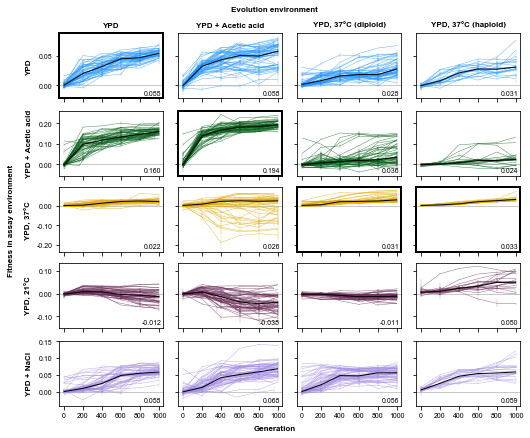

In [136]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(7,5.6), sharex=True, sharey='row', constrained_layout=True)

fig.suptitle('Evolution environment',x=.5,y=1.03,size=8, fontweight='bold')
fig.text(0.5, -0.02, 'Generation', ha='center',size=8, fontweight = 'bold')
fig.text(-0.03, 0.5, 'Fitness in assay environment', va='center', rotation='vertical',size=8, fontweight = 'bold')

rows = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']
cols = ['YPD','YPD + Acetic acid','YPD, 37°C (diploid)','YPD, 37°C (haploid)']
aecolors = ['#2497FD', '#025F17', '#E1AB06','#6B2E58','#A48DE2']

for ax, col in zip(axes[0], cols):
    ax.set_title(col, size=8,fontweight='bold')

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=8,fontweight='bold')
    
for ploidy in np.arange(2):
    ploidytest = finaltable['ploidy'] == ploidies[ploidy]
    ploidysubtable = finaltable[ploidytest]
    for ee in np.arange(len(evoenvsno10)):
        evoenvtest = ploidysubtable['evoEnvt'] == evoenvsno10[ee]
        ploidyeetable = ploidysubtable[evoenvtest]
        
        if len(ploidyeetable) > 0:
            # make a list of all the represented evocodes
            temptest1 = new_evocode_list['ploidy'] == ploidies[ploidy]
            temp_evocodes1 = new_evocode_list[temptest1]
            temptest2 = temp_evocodes1['evoEnvt'] == evoenvsno10[ee]
            temp_evocodes = temp_evocodes1[temptest2]
            temp_evocodes = temp_evocodes.drop_duplicates()
            temp_evocodes = temp_evocodes.reset_index(drop=True)

            # for each of the assay environments, plot lines for all the represented evocodes
            for assay_env in np.arange(len(envts)):
                for ec in np.arange(len(temp_evocodes)):
                    ectest = ploidyeetable['evocode'] == temp_evocodes['evocode'][ec]
                    ecsubtable = ploidyeetable[ectest]
                    ecsubtable = ecsubtable.sort_values(by=['Epoch'])
                    if ploidy == 1:
                        mym,myc,mybars = axes[assay_env,ee].errorbar(ecsubtable['Epoch-true'],ecsubtable['s_'+envts[assay_env]],xerr=None,yerr=ecsubtable['stderr(s)_'+envts[assay_env]],linewidth=0.5,elinewidth=0.3,color=aecolors[assay_env],alpha=0.7)
                        [bar.set_alpha(0.7) for bar in mybars]
                    elif ploidy == 0:
                        mym,myc,mybars = axes[assay_env,ee+1].errorbar(ecsubtable['Epoch-true'],ecsubtable['s_'+envts[assay_env]],xerr=None,yerr=ecsubtable['stderr(s)_'+envts[assay_env]],linewidth=0.5,elinewidth=0.3,color=aecolors[assay_env],alpha=0.7)
                        [bar.set_alpha(0.7) for bar in mybars]
                    
                meantable = pd.DataFrame()
                meantable['Epoch'] = ecsubtable['Epoch']
                meantable['median_s'] = ""
                meantable = meantable.reset_index(drop=True)

                for epoch in np.arange(len(epochind)):
                    tomakemean = ploidyeetable.loc[(ploidyeetable['Epoch'] == float(epochind['Epoch'][epoch]))]
                    if len(tomakemean) > 0:
                        meantable.at[epoch,'median_s'] = np.median(tomakemean['s_'+envts[assay_env]+'_adj'])
                if len(tomakemean) > 0:
                    if ploidy == 1:
                        axes[assay_env,ee].errorbar(meantable['Epoch'],meantable['median_s'],xerr=None,yerr=None,linewidth=1,color='k')
                        axes[assay_env][ee].tick_params(axis='both',labelsize=7)
                        # Add in the median gen 1000 fitness number to lower-right corner of each plot
                        medianstring = round(meantable.loc[(meantable['Epoch'] == 1000),'median_s'].values[0],3)
                        axes[assay_env,ee].text(0.98,0.05,"{:.3f}".format(medianstring),transform=axes[assay_env,ee].transAxes,
                                                ha='right',fontsize=7,color='k')
                        axes[assay_env,ee].axhline(y=0,lw=0.5,zorder=0,color='xkcd:grey')
                        
                    elif ploidy == 0:
                        axes[assay_env,ee+1].errorbar(meantable['Epoch'],meantable['median_s'],xerr=None,yerr=None,linewidth=1,color='k')
                        axes[assay_env][ee+1].tick_params(axis='both',labelsize=7)
                        # Add in the median gen 1000 fitness number to lower-right corner of each plot
                        medianstring = round(meantable.loc[(meantable['Epoch'] == 1000),'median_s'].values[0],3)
                        axes[assay_env,ee+1].text(0.98,0.05,"{:.3f}".format(medianstring),transform=axes[assay_env,ee+1].transAxes,
                                                ha='right',fontsize=7,color='k')
                        axes[assay_env,ee+1].axhline(y=0,lw=0.5,zorder=0,color='xkcd:grey')
                
                # Hide x labels and tick labels for top plots and y ticks for right plots.
                for ax in axes.flat:
                    ax.label_outer()
                    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                    ax.xaxis.set_ticks(np.arange(0,1200,200))
                    
                # For home environment plots, thick black outline
                thickb = 2
                if ploidy == 1 and assay_env == ee:
                    axes[assay_env,ee].spines['left'].set_linewidth(thickb)
                    axes[assay_env,ee].spines['right'].set_linewidth(thickb)
                    axes[assay_env,ee].spines['top'].set_linewidth(thickb)
                    axes[assay_env,ee].spines['bottom'].set_linewidth(thickb)
                elif ploidy == 0 and assay_env == 2:
                    axes[assay_env,ee+1].spines['left'].set_linewidth(thickb)
                    axes[assay_env,ee+1].spines['right'].set_linewidth(thickb)
                    axes[assay_env,ee+1].spines['top'].set_linewidth(thickb)
                    axes[assay_env,ee+1].spines['bottom'].set_linewidth(thickb)
                            

fig.align_ylabels()                


#if removingoutliers == True:
#    plt.savefig('fig2/fig2_threshold_colored_medianline_v5.jpg',bbox_inches='tight',dpi=3000)
#    plt.savefig('fig2/fig2_threshold_colored_medianline_v5.pdf',bbox_inches='tight',dpi=3000)
#else:
#    plt.savefig('fig2/fig2_unfiltered_colored_medianline_v5.jpg',bbox_inches='tight',dpi=3000)
#    plt.savefig('fig2/fig2_unfiltered_colored_medianline_v5.pdf',bbox_inches='tight',dpi=3000)          

## Figure 2B

In [7]:
# Create a new table for each non-zero timepoint
# For each table (interval), 
# for each population,
# for each assay environment,
# ask whether fitness compared to gen 0 is greater, less than, or indistinguishable.
# Then, for each evolution environment, tally the number in each of these categories.
# Put numbers into a tabular format and color according to the proportion in each category.

#theseevocodes = finaltable.loc[(finaltable['evoEnvt']!='YP10%D'),'evocode'].to_list()
#theseevocodes = list(OrderedDict.fromkeys(theseevocodes))

stattable = finaltable.copy(deep=True)

myalpha = 0.05

for i in np.arange(len(stattable)):
#for i in np.arange(1000,1001):
    for e in np.arange(len(envts)):
        if stattable.loc[i,'Epoch'] == 0:
            stattable.at[i,envts[e]+'_t'] = 'na'
            stattable.at[i,envts[e]+'_p'] = 'na'
        else:
            now_s = stattable.loc[i,'s_'+envts[e]+'_adj']
            now_stderr = stattable.loc[i,'stderr(s)_'+envts[e]]
            thisec = stattable.loc[i,'evocode']
            relevantzero_s = stattable.loc[(stattable['evocode'] == thisec)&(stattable['Epoch'] == 0),'s_'+envts[e]+'_adj'].values[0]
            relevantzero_stderr = stattable.loc[(stattable['evocode'] == thisec)&(stattable['Epoch'] == 0),'stderr(s)_'+envts[e]].values[0]
            if now_s > relevantzero_s:
                mystat,myp = stats.ttest_ind_from_stats(now_s,now_stderr,2,
                                                        relevantzero_s,relevantzero_stderr,2,
                                                        alternative = 'greater')
                if myp <= 0.05:
                    stattable.at[i,envts[e]+' comp. zero'] = 'greater'
                else:
                    stattable.at[i,envts[e]+' comp. zero'] = 'same'     
            else:
                mystat,myp = stats.ttest_ind_from_stats(now_s,now_stderr,2,
                                                        relevantzero_s,relevantzero_stderr,2,
                                                        alternative = 'less')
                if myp <= 0.05:
                    stattable.at[i,envts[e]+' comp. zero'] = 'less than'
                else:
                    stattable.at[i,envts[e]+' comp. zero'] = 'same'
            
            stattable.at[i,envts[e]+'_t'] = mystat
            stattable.at[i,envts[e]+'_p'] = myp

export_csv = stattable.to_csv(r'20210823_teststattable.csv',index=True,header=True)

# Now that the source stats table is done, tally things up
tallytab = pd.DataFrame()
myind = 0
for g in np.arange(1,6):
    for p in np.arange(len(ploidies)):
        for ee in np.arange(len(evoenvsno10)):
            temp = stattable.loc[(stattable['Epoch'] == float(epochind['Epoch'][g]))&(stattable['evoEnvt'] == evoenvsno10[ee])&(stattable['ploidy'] == ploidies[p])].copy(deep=True)
            if len(temp) > 0:
                for ae in np.arange(len(envts)):
                    numinc = len(temp.loc[(temp[envts[ae]+' comp. zero'] == 'greater')])
                    numdec = len(temp.loc[(temp[envts[ae]+' comp. zero'] == 'less than')])
                    numeq = len(temp.loc[(temp[envts[ae]+' comp. zero'] == 'same')])
                    tallytab.at[myind,'generation'] = float(epochind['Epoch'][g])
                    tallytab.at[myind,'evoEnvt'] = evoenvsno10[ee]
                    tallytab.at[myind,'ploidy'] = ploidies[p]
                    tallytab.at[myind,'assayEnvt'] = envts[ae]
                    tallytab.at[myind,'sig increase'] = numinc
                    tallytab.at[myind,'sig decrease'] = numdec
                    tallytab.at[myind,'insig'] = numeq
                    tallytab.at[myind,'sig increase frac'] = numinc/len(temp)
                    tallytab.at[myind,'sig decrease frac'] = numdec/len(temp)
                    tallytab.at[myind,'insig frac'] = numeq/len(temp)
                    
                    myind = myind + 1



C:\Users\bakor\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1922: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [ ]:
# Now create the individual formatted tables for each epoch, one at a time

ploidiesforthis = ['D','H']

for g in np.arange(1,6):
#for g in np.arange(5,6):
    epochtab = pd.DataFrame()
    myind=0
    mycol=0
    mycolnames=[]
    
    for ae in np.arange(len(envts)):
        for ee in np.arange(len(evoenvsno10)):
            for p in np.arange(len(ploidiesforthis)):
                mytemp = tallytab.loc[(tallytab['generation'] == float(epochind['Epoch'][g]))&(tallytab['evoEnvt'] == evoenvsno10[ee])&(tallytab['assayEnvt'] == envts[ae])&(tallytab['ploidy'] == ploidiesforthis[p])].copy(deep=True).reset_index(drop=True)
                if len(mytemp) > 0:
                    epochtab.at[myind,mycol] = mytemp.loc[0,'sig decrease frac']
                    mycolnames=mycolnames+[evoenvsno10[ee]+'-'+ploidiesforthis[p]+'_less fit']
                    mycol = mycol + 1
                    epochtab.at[myind,mycol] = mytemp.loc[0,'insig frac']
                    mycolnames=mycolnames+[evoenvsno10[ee]+'-'+ploidiesforthis[p]+'_eq fit']
                    mycol = mycol + 1
                    epochtab.at[myind,mycol] = mytemp.loc[0,'sig increase frac']
                    mycolnames=mycolnames+[evoenvsno10[ee]+'-'+ploidiesforthis[p]+'_more fit']
                    mycol = mycol + 1
        myind = myind + 1
        mycol = 0
        
    mycolnames = mycolnames[0:12]
    epochtab.columns = mycolnames
    epochtab.insert(0,'Assay Environment',envts)
    
    # format as %s
    epochtab2 = pd.DataFrame()
    
    for i in np.arange(len(envts)):
    #for i in np.arange(1,2):
        for j in np.arange(1,13):
        #for j in np.arange(1,len(mycolnames)+1):
            epochtab2.at[i,j] = "{:.1f}%".format(epochtab.iloc[i,j]*100)
    epochtab2.columns = mycolnames
    epochtab2.insert(0,'Assay Environment',envts)
    
    #get colors
    norm = plt.Normalize(0,1.6)
    myvals = epochtab.iloc[:,1:13].values
    colors = []
    for i in np.arange(len(envts)):
        rowcolor = []
        for j in np.arange(12):
            thisval = myvals[i][j]
            if j % 3 == 0:
                thiscolor = list(plt.cm.Blues(norm(thisval)))
            elif (j+1) % 3 == 0:
                thiscolor = list(plt.cm.Oranges(norm(thisval)))
            else:
                thiscolor = list(plt.cm.Greys(norm(thisval)))
            rowcolor=rowcolor+[thiscolor]
        colors = colors + [rowcolor]
    colors = np.array(colors)
    
    mytabvals = epochtab2.iloc[:,1:13].values
    mycolnamesabbrev = ['less fit','equally fit','more fit','less fit','equally fit','more fit','less fit','equally fit','more fit','less fit','equally fit','more fit']
    
    fig = plt.figure(figsize=(30*.76,16))
    fig,ax = plt.subplots(figsize=(30*.76,16))
    ax.set_axis_off()
    
    #ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

    the_table=ax.table(cellText=mytabvals, rowLabels=['YPD','YPD + Acetic Acid','YPD, 37°C','YPD, 21°C','YPD + NaCl'], colLabels=mycolnamesabbrev, 
                        colWidths = [0.03]*mytabvals.shape[1], loc='center', 
                        cellColours=colors,cellLoc = 'center')
    #plt.axhline(0,color='xkcd:magenta')
    #plt.axhline(0.5,color='xkcd:gold')
    
    # increasing second number increases height
    #the_table.scale(1,3)
    the_table.set_fontsize(30)
    
    #mydecvals = epochtab.loc[:,mycolnames[::3]].values
    #myeqvals = epochtab.loc[:,mycolnames[1::3]].values
    #myincvals = epochtab.loc[:,mycolnames[2::3]].values
    #colorsdec = plt.cm.Oranges(norm(mydecvals))
    #colorseq = plt.cm.Greys(norm(myeqvals))
    #colorsinc = plt.cm.Blues(norm(myincvals))
    
    plt.savefig(epochind['Epoch'][g]+'_table_v3c.pdf',bbox_inches='tight',dpi=750)
    
    ## Now reimport and crop table image
    ## Opens a image in RGB mode
    #im = Image.open(epochind['Epoch'][g]+'_table_v3b.pdf')

    ## Size of the image in pixels (size of original image)
    ## (This is not mandatory)
    #width, height = im.size

    ## Setting the points for cropped image
    #left = width/3.9 #a
    ##left = width/3.7
    #top = height / 2.4
    #right = width - left*1.15
    #bottom = height - top

    ## Cropped image of above dimension
    ## (It will not change original image)
    #im1 = im.crop((left, top, right, bottom))
    
    ## Need to get from RGBA to RGB format
    #im1.load()
    #background = Image.new("RGB", im1.size)
    #background.paste(im1, mask=im1.split()[3]) # 3 is the alpha channel

    #background.save(epochind['Epoch'][g]+'_table_v3b_crop.pdf',dpi=(750, 750))

    # Shows the image in image viewer
    #im1.show()
    #im1 = im1.save(epochind['Epoch'][g]+'_table_v3a.pdf',dpi=(750, 750))
    
# next steps:
# Will add evo envt names and n in post (illustrator)
    
    

## Analysis to show extent of declining adaptability

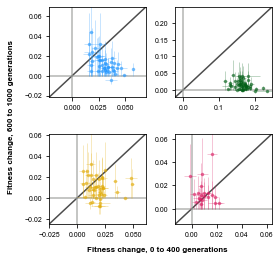

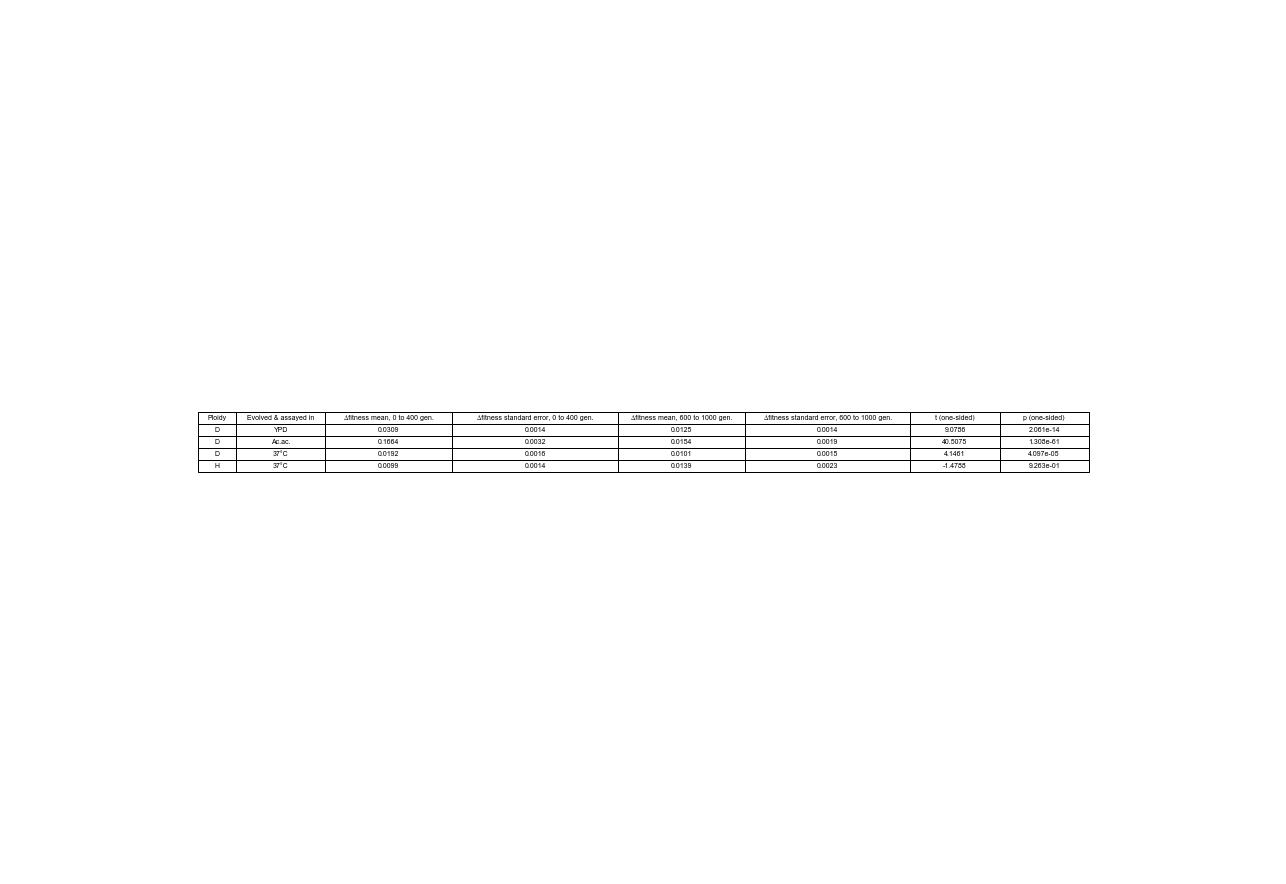

In [60]:
da = pd.DataFrame()
dastr = pd.DataFrame()

wtab = finaltable.copy(deep=True)
wtab = wtab.loc[wtab['evoEnvt'] != 'YP10%D'].reset_index(drop=True)

tplist = ['0','200','400','600','800','1000']

ploidiesforthis = ['D','H']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4,4), sharex=False, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

fig.text(0.5, 0.03, 'Fitness change, 0 to 400 generations', ha='center',size=8, fontweight = 'bold')
fig.text(-0.02, 0.5, 'Fitness change, 600 to 1000 generations', va='center', rotation='vertical',size=8, fontweight = 'bold')

eecolors = ['#2497FD', '#025F17', '#E1AB06', '#D81B60']

myind = 0

#for p in np.arange(0,1):
for p in np.arange(len(ploidiesforthis)):
    #for ee in np.arange(0,1):
    for ee in np.arange(len(evoenvsno10)):
        temp = wtab.loc[(wtab['evoEnvt'] == evoenvsno10[ee])&(wtab['ploidy'] == ploidiesforthis[p])]
        if len(temp) > 0:
            myecs = temp['evocode'].to_list()
            myecs = list(OrderedDict.fromkeys(myecs))
            for ae in np.arange(len(envts)):
                flag = 'n'
                if p == 0:
                    if ee == ae:
                        flag = 'y'
                        
                elif p == 1:
                    if envts[ae] == '37':
                        flag = 'y'                  
                
                if flag == 'y':
                    #print(ploidiesforthis[p]+'-'+evoenvsno10[ee]+'_'+envts[ae]+' is yes')
                    plotgeist = pd.DataFrame()
                    for pop in np.arange(len(myecs)):
                        plotgeist.at[pop,'evocode'] = myecs[pop]
                        for g in np.arange(len(tplist)):
                            plotgeist.at[pop,tplist[g]+'_s'] = temp.loc[(temp['evocode'] == myecs[pop])&(temp['Epoch'] == float(tplist[g])),'s_'+envts[ae]+'_adj'].values[0]
                            plotgeist.at[pop,tplist[g]+'_stderr(s)'] = temp.loc[(temp['evocode'] == myecs[pop])&(temp['Epoch'] == float(tplist[g])),'stderr(s)_'+envts[ae]].values[0]                                             

                    # with this table, calculate the differences
                    plotgeist['400-0_s'] = plotgeist['400_s'] - plotgeist['0_s']
                    #plotgeist['1000-200_s'] = plotgeist['1000_s'] - plotgeist['200_s']
                    #plotgeist['1000-400_s'] = plotgeist['1000_s'] - plotgeist['400_s']
                    plotgeist['1000-600_s'] = plotgeist['1000_s'] - plotgeist['600_s']
                    #plotgeist['1000-800_s'] = plotgeist['1000_s'] - plotgeist['800_s']

                    # do the errors now
                    plotgeist['400-0_stderr(s)'] = np.sqrt(plotgeist['400_stderr(s)']**2 + plotgeist['0_stderr(s)']**2)
                    plotgeist['1000-600_stderr(s)'] = np.sqrt(plotgeist['1000_stderr(s)']**2 + plotgeist['600_stderr(s)']**2)

                    # plot the differences
                    # get axes
                    figt, axt = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
                    axt.scatter(plotgeist['400-0_s'],plotgeist['1000-600_s'])
                    xs = axt.get_xlim()
                    ys = axt.get_ylim()
                    #plt.figure(1)
                    #plt.scatter(plotgeist['400-0_s'],plotgeist['1000-600_s'],linestyle='None')
                    #xs = plt.gca().get_xlim()
                    #ys = plt.gca().get_ylim()
                    myxys = (min(xs[0],ys[0]),max(xs[1],ys[1]))
                    #plt.close(1)
                    plt.close(figt)
                    #plt.show()
                    
                    if (p+ee) < 2:
                        row = 0
                    else:
                        row = 1
                    if (p+ee) % 2 == 0:
                        col = 0
                    else:
                        col = 1

                    markers,caps,bars = axes[row,col].errorbar(plotgeist['400-0_s'],plotgeist['1000-600_s'],xerr=plotgeist['400-0_stderr(s)'],yerr=plotgeist['1000-600_s'],
                                                      linestyle='None',marker='.',ms=5,alpha=0.5,elinewidth=0.5,color=eecolors[myind])

                    [bar.set_alpha(0.5) for bar in bars]

                    mainx = np.linspace(-1,1)
                    axes[row,col].plot(mainx,mainx,zorder=0,color='k',alpha=0.7)
                    axes[row,col].axhline(y=0,color='xkcd:grey',zorder=0,alpha=0.7)
                    axes[row,col].axvline(x=0,color='xkcd:grey',zorder=0,alpha=0.7)
                    axes[row,col].set_xlim(myxys)
                    axes[row,col].set_ylim(myxys)
                    axes[row,col].tick_params(axis='both',labelsize=7)
                    
                    # Do the analysis part of this
                    da.at[myind,'ploidy'] = ploidiesforthis[p]
                    da.at[myind,'evoEnvt'] = evoenvsno10[ee]
                    da.at[myind,'assayEnvt'] = envts[ae]
                    da.at[myind,'400-0_mean'] = plotgeist['400-0_s'].mean()
                    da.at[myind,'400-0_stderr'] = stats.sem(plotgeist['400-0_s'])
                    da.at[myind,'1000-600_mean'] = plotgeist['1000-600_s'].mean()
                    da.at[myind,'1000-600_stderr'] = stats.sem(plotgeist['1000-600_s'])
                    
                    
                    myt,myp = stats.ttest_ind(plotgeist['400-0_s'], plotgeist['1000-600_s'], alternative='greater')
                    
                    da.at[myind,'t (one-sided)'] = myt
                    da.at[myind,'p (one-sided)'] = myp
                    
                    # for table
                    dastr.at[myind,'Ploidy'] = ploidiesforthis[p]
                    dastr.at[myind,'Evolved & assayed in'] = envts_abbrevofficial[ee]
                    dastr.at[myind,'∆fitness mean, 0 to 400 gen.'] = str(round(plotgeist['400-0_s'].mean(),4))
                    dastr.at[myind,'∆fitness standard error, 0 to 400 gen.'] = str(round(stats.sem(plotgeist['400-0_s']),4))
                    dastr.at[myind,'∆fitness mean, 600 to 1000 gen.'] = str(round(plotgeist['1000-600_s'].mean(),4))
                    dastr.at[myind,'∆fitness standard error, 600 to 1000 gen.'] = str(round(stats.sem(plotgeist['1000-600_s']),4))
                    dastr.at[myind,'t (one-sided)'] = str(round(myt,4))
                    dastr.at[myind,'p (one-sided)'] = str('{:0.3e}'.format(myp))
                    
                    myind = myind + 1
                    
                    flag = 'n'
                    

#fig.savefig('decadapt_v01.pdf',bbox_inches='tight',dpi=300)
#plt.show()

# make the table of the analysis in pyplot
fig,ax = plt.subplots(figsize=(30*.76,16))
ax.set_axis_off()

mycols = ['Ploidy','Evolved & assayed in','\n'.join(wrap('∆fitness mean, 0 to 400 gen.',14)),'\n'.join(wrap('∆fitness standard error, 0 to 400 gen.',24)),'\n'.join(wrap('∆fitness mean, 600 to 1000 gen.',14)),'\n'.join(wrap('∆fitness standard error, 600 to 1000 gen.',24)),'t (one-sided)','p (one-sided)']

the_table=ax.table(cellText=dastr.values, colLabels=list(dastr.columns), loc='center', cellLoc = 'center',
                   colWidths=[0.03,0.07,0.1,0.13,0.1,0.13,0.07,0.07])
#plt.axhline(0,color='xkcd:magenta')
#plt.axhline(0.5,color='xkcd:gold')

# increasing second number increases height
#the_table.scale(1,3)
the_table.set_fontsize(30)

plt.savefig('decadapt_table_v01.pdf',bbox_inches='tight',dpi=750)

## Figure 5–figure supplement 2 (Brown-Forsythe test)

In [ ]:
#Browne-Forsythe test to test whether var(home) < var(away)

# Formally assess variability across time points and environments using Levene's test (i.e., Browne-Forsythe)
# https://en.wikipedia.org/wiki/Levene%27s_test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
# I'll get the one-sided result as described here:
# https://stats.stackexchange.com/questions/69253/one-tailed-levene-test

myforlev = finaltable.copy(deep=True)
myforlev = myforlev.loc[myforlev['evoEnvt'] != 'YP10%D'].reset_index(drop=True)
myforlev['evoEnvt-ploidy'] = myforlev['evoEnvt']+'-'+myforlev['ploidy']

eetargets = ['YPD-D','YPD+AA-D','YPD(37C)-D','YPD(37C)-H']
eetargetshome = ['30','AA','37','37']

levtab = pd.DataFrame()
levtab['assay_env'] = envts

comparison_counter = 0 # to give the # of comparisons

for ee in np.arange(len(eetargets)):
    for ae in np.arange(len(envts)):
        for g in np.arange(len(epochind)):
            if envts[ae] == eetargetshome[ee]:
                levtab.at[(levtab['assay_env'] == envts[ae]),eetargets[ee]+'-'+epochind['Epoch'][g]] = np.nan
            else:
                temp = myforlev.loc[(myforlev['evoEnvt-ploidy'] == eetargets[ee])&(myforlev['Epoch'] == float(epochind['Epoch'][g]))]
                # Run brown-forsythe
                h = temp['s_'+eetargetshome[ee]+'_adj']
                a = temp['s_'+envts[ae]+'_adj']
                BF, BFp = stats.levene(h,a,center='median')
                
                #two-tailed t-test on transformed data
                zh = abs(h-statistics.median(h))
                za = abs(a-statistics.median(a))
                myt, myp_2tail = stats.ttest_ind(zh, za)
                
                # one-tailed t test p value
                # for degrees of freedom, use number of pops minus 1
                # subtracting from 1 gives probability home variance is less than away variance
                myp_1tail = 1 - stats.t.sf(myt, len(zh)-1)
                
                levtab.at[(levtab['assay_env'] == envts[ae]),eetargets[ee]+'-'+epochind['Epoch'][g]] = myp_1tail
                
                comparison_counter = comparison_counter + 1

main_alpha = 0.05

count_mainalpha_sigp = 0

for ee in np.arange(len(eetargets)):
    for ae in np.arange(len(envts)):
        for g in np.arange(len(epochind)):
            thisp = levtab.loc[(levtab['assay_env'] == envts[ae]),eetargets[ee]+'-'+epochind['Epoch'][g]].values[0]
            if thisp < main_alpha:
                count_mainalpha_sigp = count_mainalpha_sigp + 1

count_mainalpha_sigp

#export_csv = levtab.to_csv(r'20210420_levene_v01.csv',index=True,header=True)

# Make heat map
mycolorsforheat = ["xkcd:baby blue",'xkcd:grey','xkcd:faded red']

mycmap = mcolors.ListedColormap(mycolorsforheat)
boundaries = [0,0.05,0.95,1]
#boundaries = [0,0.005,0.05,0.10,0.95,1]
mynorm = mcolors.BoundaryNorm(boundaries, mycmap.N, clip=True)

#levtab = levtab.fillna(1)
levtabarr = np.array(levtab[levtab.columns.tolist()[1:]],dtype='f')

fig,ax = plt.subplots(figsize=(6,1))

ax = sns.heatmap(levtabarr,
                 #xticklabels=envts,
                 yticklabels=envts,
                 #center=0,
                 cmap=mycmap,norm=mynorm,cbar=False)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(envts_abbrevofficial,rotation=0)
#ax.set_yticklabels(envts,rotation='horizontal')
ax.set_xticklabels(epochind['Epoch'].to_list()*6,rotation=45)
ax.set_xlabel('Generation')
ax.set_ylabel('Assay env.')

for ee in np.arange(len(evoenvsno10)):
    ax.vlines([6*(ee+1)], *ax.get_ylim())

mylw = 4                

prange = [str(boundaries[0])+' < p < '+str(boundaries[1]),
          str(boundaries[1])+' ≤ p < '+str(boundaries[2]),
          str(boundaries[2])+' ≤ p < '+str(boundaries[3])]

custom_lines = [Line2D([0], [0], color=mycolorsforheat[0], lw=mylw),
                Line2D([0], [0], color=mycolorsforheat[1], lw=mylw),
                Line2D([0], [0], color=mycolorsforheat[2], lw=mylw)]

plt.rcParams['legend.title_fontsize'] = 7
leg = fig.legend(custom_lines,prange,loc='upper left',bbox_to_anchor=(0.91,1.55),
                 fontsize=7,title='p range',handlelength=0.3,borderaxespad=1,frameon=False)
leg._legend_box.align = "left"

#if removingoutliers == True:
#    plt.savefig('brownforsythe_threshold_v1.jpg',bbox_inches='tight',dpi=300)
#    plt.savefig('brownforsythe_threshold_v1.pdf',bbox_inches='tight',dpi=300)
#else:
#    plt.savefig('brownforsythe_unfiltered_v1.jpg',bbox_inches='tight',dpi=300)
#    plt.savefig('brownforsythe_unfiltered_v1.pdf',bbox_inches='tight',dpi=300)          

## Figure 3

In [ ]:
# Let's summarize movement in 2D envt spaces

wtab = finaltable.copy(deep=True)

# start with an evocode_list that is without YP10
evocode_listupdate = new_evocode_list.copy(deep = True)
evocode_listupdate['evoEnvt-ploidy'] = evocode_listupdate['evoEnvt']+"-"+evocode_listupdate['ploidy'].map(str)
evocode_listupdate['evoEnvt-ploidy-LP'] = evocode_listupdate['evoEnvt-ploidy']+"-"+evocode_listupdate['LP'].map(str)
# remove the YP10 guys
tentest = evocode_listupdate['evoEnvt'] != 'YP10%D'
evocode_listupdate = evocode_listupdate[tentest]
evocode_listupdate = evocode_listupdate.reset_index(drop=True)


# create comprehensive list of assay environment pairs
envtpairsno10 = [['30','37'],['30','AA'],['30','RT'],['30','NaCl'],['37','AA'],['37','RT'],['37','NaCl'],['AA','RT'],['AA','NaCl'],['RT','NaCl']]

mywidth = 0.5
myalpha = 0.5
myalphas = [0.3,0.4,0.5,0.6,0.7]
mywidths = [1.5,1.5,1.5,1.5,1.5]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(9,9), sharex=False, sharey=False)

names = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']

for ax, col in zip(axes[0], names):
    ax.set_title(col, size=8, fontweight='bold')

for ax, row in zip(axes[:,0], names):
    ax.set_ylabel(row, rotation=90, size=8, fontweight='bold')
    
for e1 in np.arange(len(envts)):
    for e2 in np.arange(len(envts)):
        for epoch in np.arange(1):
            subt = wtab.loc[(wtab['Epoch'] <= float(epochind['Epoch'][epoch+5]))]
            for ec in np.arange(len(evocode_listupdate)):
                subtec = subt.loc[(subt['evocode'] == evocode_listupdate.loc[ec,'evocode'])]
                if evocode_listupdate.loc[ec,'ploidy'] == 'H':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#D81B60',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD(37C)':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#E1AB06',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#2497FD',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD+AA':    
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#025F17',alpha=myalpha,linewidth=mywidth)
                axes[e2,e1].tick_params(axis='both',labelsize=7)
            
            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axes.flat:
                ax.label_outer()
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        axes[e2,e1].axhline(y=0,linewidth=0.5,color='xkcd:grey')
        axes[e2,e1].axvline(x=0,linewidth=0.5,color='xkcd:grey')
                
mylw = 2                
eenames = ['YPD','YPD + Acetic acid','YPD, 37°C (diploid)','YPD, 37°C (haploid)']
custom_lines = [Line2D([0], [0], color='#2497FD', lw=mylw),
                Line2D([0], [0], color='#025F17', lw=mylw),
                Line2D([0], [0], color='#E1AB06', lw=mylw),
                Line2D([0], [0], color='#D81B60', lw=mylw)]

plt.rcParams['legend.title_fontsize'] = 7
leg = fig.legend(custom_lines,eenames,loc='upper left',bbox_to_anchor=(0.26, 0.15, 0.5, 0.5),
                 fontsize=7,title='Evolution environment')
leg._legend_box.align = "left"

fig.align_ylabels()


# remove redundant plots
delax = [[0,0],[0,1],[0,2],[0,3],[0,4]
        ,[1,1],[1,2],[1,3],[1,4]
        ,[2,2],[2,3],[2,4]
        ,[3,3],[3,4]
        ,[4,4]]
for pair in np.arange(len(delax)):
    fig.delaxes(axes[delax[pair][0]][delax[pair][1]])
    
for i in np.arange(4):
    axes[4,i].set_xlabel(names[i],fontsize=8,fontweight='bold')

    
fig.text(0.43, 0.065, 'Fitness in assay environment', ha='center',size=10, fontweight = 'bold')
fig.text(0.04, 0.43, 'Fitness in assay environment', va='center', rotation='vertical',size=10, fontweight = 'bold')

# For the gif below, get the axes limits
xlimlist = []
ylimlist = []
for i in np.arange(4):
    xlimlist = xlimlist + [axes[4][i].get_xlim()]
    ylimlist = ylimlist + [axes[i+1][0].get_ylim()]

#if removingoutliers == True:
    #plt.savefig('fig3/fig3_threshold_v12.jpg',bbox_inches='tight',dpi=3000)
    #plt.savefig('fig3/fig3_threshold_v12.pdf',bbox_inches='tight',dpi=3000)
#else:
    #plt.savefig('fig3/fig3_unfiltered_v12.jpg',bbox_inches='tight',dpi=3000)
    #plt.savefig('fig3/fig3_unfiltered_v12.pdf',bbox_inches='tight',dpi=3000)


## Figure 3 .gif

In [ ]:
# Generate 6 frames that will make up a gif
# Run only after the above, which gets the axes limits

wtab = finaltable.copy(deep=True)

# start with an evocode_list that is without YP10
evocode_listupdate = new_evocode_list.copy(deep = True)
evocode_listupdate['evoEnvt-ploidy'] = evocode_listupdate['evoEnvt']+"-"+evocode_listupdate['ploidy'].map(str)
evocode_listupdate['evoEnvt-ploidy-LP'] = evocode_listupdate['evoEnvt-ploidy']+"-"+evocode_listupdate['LP'].map(str)
# remove the YP10 guys
tentest = evocode_listupdate['evoEnvt'] != 'YP10%D'
evocode_listupdate = evocode_listupdate[tentest]
evocode_listupdate = evocode_listupdate.reset_index(drop=True)

# create comprehensive list of assay environment pairs
envtpairsno10 = [['30','37'],['30','AA'],['30','RT'],['30','NaCl'],['37','AA'],['37','RT'],['37','NaCl'],['AA','RT'],['AA','NaCl'],['RT','NaCl']]

mywidth = 0.5
myalpha = 0.5
myalphas = [0.3,0.4,0.5,0.6,0.7]
mywidths = [1.5,1.5,1.5,1.5,1.5]

names = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']

filenames_gif_thresh = []
filenames_gif_unfil = []

for g in np.arange(1,len(epochind)):

    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(9,9), sharex=False, sharey=False)

    for ax, col in zip(axes[0], names):
        ax.set_title(col, size=8, fontweight='bold')

    for ax, row in zip(axes[:,0], names):
        ax.set_ylabel(row, rotation=90, size=8, fontweight='bold')

    for e1 in np.arange(len(envts)):
        for e2 in np.arange(len(envts)):
            subt = wtab.loc[(wtab['Epoch'] <= float(epochind['Epoch'][g]))]
            for ec in np.arange(len(evocode_listupdate)):
                subtec = subt.loc[(subt['evocode'] == evocode_listupdate.loc[ec,'evocode'])]
                if evocode_listupdate.loc[ec,'ploidy'] == 'H':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#D81B60',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD(37C)':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#E1AB06',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD':
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#2497FD',alpha=myalpha,linewidth=mywidth)
                elif evocode_listupdate.loc[ec,'evoEnvt'] == 'YPD+AA':    
                    axes[e2,e1].plot(subtec['s_'+envts[e1]+'_adj'],subtec['s_'+envts[e2]+'_adj'],color='#025F17',alpha=myalpha,linewidth=mywidth)
                axes[e2,e1].tick_params(axis='both',labelsize=7)
            
            # set x and y limits
            if e1 < 4:
                axes[e2,e1].set_xlim(xlimlist[e1])
            if e2 > 0:
                axes[e2,e1].set_ylim(ylimlist[e2-1])

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axes.flat:
                ax.label_outer()
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
            axes[e2,e1].axhline(y=0,linewidth=0.5,color='xkcd:grey')
            axes[e2,e1].axvline(x=0,linewidth=0.5,color='xkcd:grey')

    mylw = 2                
    eenames = ['YPD','YPD + Acetic acid','YPD, 37°C (diploid)','YPD, 37°C (haploid)']
    custom_lines = [Line2D([0], [0], color='#2497FD', lw=mylw),
                    Line2D([0], [0], color='#025F17', lw=mylw),
                    Line2D([0], [0], color='#E1AB06', lw=mylw),
                    Line2D([0], [0], color='#D81B60', lw=mylw)]

    plt.rcParams['legend.title_fontsize'] = 7
    leg = fig.legend(custom_lines,eenames,loc='upper left',bbox_to_anchor=(0.26, 0.15, 0.5, 0.5),
                     fontsize=7,title='Evolution environment')
    leg._legend_box.align = "left"

    fig.align_ylabels()


    # remove redundant plots
    delax = [[0,0],[0,1],[0,2],[0,3],[0,4]
            ,[1,1],[1,2],[1,3],[1,4]
            ,[2,2],[2,3],[2,4]
            ,[3,3],[3,4]
            ,[4,4]]
    for pair in np.arange(len(delax)):
        fig.delaxes(axes[delax[pair][0]][delax[pair][1]])

    for i in np.arange(4):
        axes[4,i].set_xlabel(names[i],fontsize=8,fontweight='bold')

    fig.text(0.43, 0.065, 'Fitness in assay environment', ha='center',size=10, fontweight = 'bold')
    fig.text(0.04, 0.43, 'Fitness in assay environment', va='center', rotation='vertical',size=10, fontweight = 'bold')
    
    # Add a generation counter thing
    fig.text(0.51,0.5,'Generation '+epochind['Epoch'][g],size=18)

    if removingoutliers == True:
        f = 'fig3/fig3_threshold_'+epochind['Epoch'][g]+'.jpg'
        plt.savefig(f,bbox_inches='tight',dpi=300)
        filenames_gif_thresh = filenames_gif_thresh + [f]
    else:
        f = 'fig3/fig3_unfiltered_'+epochind['Epoch'][g]+'.jpg'
        plt.savefig(f,bbox_inches='tight',dpi=300)
        filenames_gif_unfil = filenames_gif_unfil + [f]

# Generate the gif
myd = 1

if removingoutliers == True:    
    images = []
    for filename in filenames_gif_thresh:
        images.append(imageio.imread(filename))
    imageio.mimsave('Fig3_thresh.gif', images, duration=myd)
else:
    images = []
    for filename in filenames_gif_unfil:
        images.append(imageio.imread(filename))
    imageio.mimsave('Fig3_unfil.gif', images, duration=myd)

## Generate s bootstraps 

In [ ]:
# Load the final s table
if removingoutliers == True:
    myfinaltable = pd.read_csv("20210413_final_s_table_threshold.csv")
else:
    myfinaltable = pd.read_csv("20210413_final_s_table_unfiltered.csv")

# Generate bootstrap tables

nboot = 100

intervals = ['10-30','30-50']

#for n in np.arange(1):
for n in np.arange(nboot):
    boots = pd.DataFrame()
    boots['Epoch'] = myfinaltable['Epoch']
    boots['LP'] = myfinaltable['LP']
    boots['evoEnvt'] = myfinaltable['evoEnvt']
    boots['evocode'] = myfinaltable['evocode']
    boots['evocode-Epoch'] = myfinaltable['evocode-Epoch']
    boots['ploidy'] = myfinaltable['ploidy']
    boots['Epoch-true'] = myfinaltable['Epoch-true']
    
    for envt in np.arange(len(envts)):
        new_s = []
        for evep in np.arange(len(boots)):
            # identify the possible interval s values to choose from
            shoebox = []
            for i in np.arange(len(intervals)):
                for rep in np.arange(2):
                    if ~np.isnan(myfinaltable.loc[evep,'s_'+intervals[i]+'_'+envts[envt]+'-rep'+reps[rep]]):
                        shoebox = shoebox + [myfinaltable.loc[evep,'s_'+intervals[i]+'_'+envts[envt]+'-rep'+reps[rep]]]
            # choose interval s values for the bootstrap
            newshoes = []
            for sb in np.arange(len(shoebox)):
                newshoes = newshoes + [shoebox[randrange(len(shoebox))]]
            new_s = new_s + [np.nanmean(newshoes)]
        boots['s_'+envts[envt]] = new_s
        
    # Now create the s_adj values that interpolate/extrapolate fitness for the p2 populations
    for envt in np.arange(len(envts)):
        boots['s_'+envts[envt]+'_adj'] = ""
    
    for envt in np.arange(len(envts)):
        for ece in np.arange(len(boots)):
            if boots.loc[ece,'evocode'][1] == '2' and boots.loc[ece,'Epoch'] > 0:
                if boots.loc[ece,'Epoch-true'] < 960:
                    this_s = boots.loc[ece,'s_'+envts[envt]]
                    next_s = boots.loc[(boots['evocode'] == boots.loc[ece,'evocode']) &
                                            (boots['Epoch-true'] == boots.loc[ece,'Epoch-true'] + 200)]['s_'+envts[envt]].iloc[0]
                    my_m = (next_s - this_s)/200
                    my_b = this_s - boots.loc[ece,'Epoch-true'] * my_m
                    new_s = my_m * boots.loc[ece,'Epoch'] + my_b
                    boots.at[ece,'s_'+envts[envt]+'_adj'] = new_s
                else:
                    this_s = boots.loc[ece,'s_'+envts[envt]]
                    prev_s = boots.loc[(boots['evocode'] == boots.loc[ece,'evocode']) &
                                            (boots['Epoch-true'] == boots.loc[ece,'Epoch-true'] - 200)]['s_'+envts[envt]].iloc[0]
                    my_m = (this_s - prev_s)/200
                    my_b = this_s - boots.loc[ece,'Epoch-true'] * my_m
                    new_s = my_m * boots.loc[ece,'Epoch'] + my_b
                    boots.at[ece,'s_'+envts[envt]+'_adj'] = new_s                
            else:
                boots.at[ece,'s_'+envts[envt]+'_adj'] = boots.loc[ece,'s_'+envts[envt]] 
    
    # GENERATE BOOTSTRAPS HERE
    #if removingoutliers == True:
        #export_csv = boots.to_csv(r'bootstraps/s/20210413_final_s_table_threshold_'+str(n)+'_wadj.csv',index=True,header=True)
    #else:
        #export_csv = boots.to_csv(r'bootstraps/s/20210413_final_s_table_unfiltered_'+str(n)+'_wadj.csv',index=True,header=True)

## Figure 4 (PCAs)

### Figure 4A

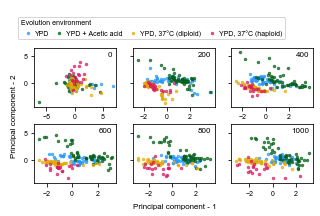

In [86]:
# Get Figure 4A

# Redo what's immediately above in 2r3c format

fig0,ax0 = plt.subplots(nrows=2, ncols=3, figsize=(5,3*0.83),sharey='row',sharex=False)
fig0.subplots_adjust(hspace=0.3,wspace=0.2)

# DO THE 6 TIMECOURSE SUBPLOTS
# start with an evocode_list that is without YP10
evocode_listupdate = new_evocode_list.copy(deep = True)
evocode_listupdate['evoEnvt-ploidy'] = evocode_listupdate['evoEnvt']+"-"+evocode_listupdate['ploidy'].map(str)
evocode_listupdate['evoEnvt-ploidy-LP'] = evocode_listupdate['evoEnvt-ploidy']+"-"+evocode_listupdate['LP'].map(str)
# remove the YP10 guys
tentest = evocode_listupdate['evoEnvt'] != 'YP10%D'
evocode_listupdate = evocode_listupdate[tentest]
evocode_listupdate = evocode_listupdate.reset_index(drop=True)

# go through the evocode list and create a column for each fitness at each epoch (AA, NaCl, etc.). Basically,
# just locate the evocode-epoch (e.g., p8-D3) and fill in the appropriate fitness values into each of 5 lists.
# this first one will be without breaking out the RT into 10-30 and 30-50

endtable = evocode_listupdate

for e in np.arange(len(epochind)):
    YPDendlist = []
    YPD37endlist = []
    AAendlist = []
    RTendlist = []
    NaClendlist = []

    for ec in np.arange(len(evocode_listupdate)):
        picked = finaltable.loc[finaltable['evocode-Epoch'] == evocode_listupdate['evocode'][ec]+'-'+epochind['Epoch'][e]]
        picked = picked.reset_index(drop=True)
        YPDendlist = YPDendlist + [picked.loc[0,'s_30_adj']]
        YPD37endlist = YPD37endlist + [picked.loc[0,'s_37_adj']]
        AAendlist = AAendlist + [picked.loc[0,'s_AA_adj']]
        RTendlist = RTendlist + [picked.loc[0,'s_RT_adj']]
        NaClendlist = NaClendlist + [picked.loc[0,'s_NaCl_adj']]

    endtable['30-'+epochind['Epoch'][e]] = YPDendlist
    endtable['37-'+epochind['Epoch'][e]] = YPD37endlist
    endtable['AA-'+epochind['Epoch'][e]] = AAendlist
    endtable['RT-'+epochind['Epoch'][e]] = RTendlist
    endtable['NaCl-'+epochind['Epoch'][e]] = NaClendlist


# now normalize this endtable data (standardization), since PCA output influenced by scale of data features.
# ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
# Apply normalization with sklearn's StandardScaler. Want it to normalize such that it has a mean of 0, sd of 1,
# Normally distributed.

varexptable = pd.DataFrame()

# more useful definitions for the unfurled loop :(
npc_end = 2
targets = ['YPD-D','YPD+AA-D','YPD(37C)-D','YPD(37C)-H']
newnames = ['YPD','YPD + Acetic acid','YPD, 37°C (diploid)','YPD, 37°C (haploid)']
colors = ['#2497FD', '#025F17', '#E1AB06','#D81B60']

if removingoutliers == True:
    ylimlow = -4.36
    ylimhigh = 6.54
else:
    ylimlow = -5
    ylimhigh = 6.5

# Note that the below plotting will cause deprecation warnings to come up, but these can be safely ignored
# according to the internet.

axlist = [[0,0],[0,1],[0,2],
          [1,0],[1,1],[1,2]]

componentstable = pd.DataFrame()
componentstable['assay environment'] = ['30C','37C','Ac ac','21C','NaCl']
expvartable = pd.DataFrame()
expvartable['component'] = [1,2]

for e in np.arange(6):
    specendtable = endtable[list(endtable)[:6]+list(endtable)[6+5*e:11+5*e]].copy(deep=True)

    endfeatures = list(specendtable)[6:len(list(specendtable))]
    norm_endtable = specendtable.loc[:,endfeatures].values
    norm_endtable = StandardScaler().fit_transform(norm_endtable)

    # now re-project data to n principle components
    pca_end = PCA(n_components = npc_end)
    principalcomponents_end = pca_end.fit_transform(norm_endtable)

    # plot now
    pcend_df = pd.DataFrame(data = principalcomponents_end
                           , columns = ['principal component 1', 'principal component 2'])

    for target, color in zip(targets,colors):
        indicesToKeep = specendtable['evoEnvt-ploidy'] == target
        if removingoutliers == True:
            if e < 5:
                ax0[axlist[e][0]][axlist[e][1]].scatter(pcend_df.loc[indicesToKeep, 'principal component 1'],
                            pcend_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 6, alpha=0.7)
            else:
                ax0[axlist[e][0]][axlist[e][1]].scatter(-pcend_df.loc[indicesToKeep, 'principal component 1'],
                            pcend_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 6, alpha=0.7)
        if removingoutliers == False:
            if e != 1:
                ax0[axlist[e][0]][axlist[e][1]].scatter(pcend_df.loc[indicesToKeep, 'principal component 1'],
                            pcend_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 6, alpha=0.7)
            else:
                ax0[axlist[e][0]][axlist[e][1]].scatter(pcend_df.loc[indicesToKeep, 'principal component 1'],
                            -pcend_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 6, alpha=0.7)
        ax0[axlist[e][0]][axlist[e][1]].set_ylim([ylimlow,ylimhigh])
    
    ax0[axlist[e][0]][axlist[e][1]].tick_params(axis='both',labelsize=7)

    if e == 0:
        ax0[axlist[e][0]][axlist[e][1]].set_xticks([-5,0,5])
    else:
        ax0[axlist[e][0]][axlist[e][1]].set_xticks([-2,0,2])
    
    # Put on generation labels
    ydiff = ylimhigh - ylimlow
    diffx = ax0[axlist[e][0]][axlist[e][1]].get_xlim()[1]- ax0[axlist[e][0]][axlist[e][1]].get_xlim()[0]
    ax0[axlist[e][0]][axlist[e][1]].text(ax0[axlist[e][0]][axlist[e][1]].get_xlim()[1] - diffx*0.05,ylimhigh - ydiff*0.05,epochind['Epoch'][e],
               verticalalignment='top',horizontalalignment='right',fontsize=8)
    
    # Export PCs
    endtable['PC1-'+epochind['Epoch'][e]] = pcend_df['principal component 1']
    endtable['PC2-'+epochind['Epoch'][e]] = pcend_df['principal component 2']
    
    # Export components
    thiscomponentstable = pd.DataFrame(pca_end.components_).T
    thiscomponentstable = thiscomponentstable.rename(columns={0:'Contribution to PC1-'+epochind['Epoch'][e],1:'Contribution to PC2-'+epochind['Epoch'][e]})
    thiscomponentstable.insert(0,'assay environment',['30C','37C','Ac ac','21C','NaCl'])
    componentstable = pd.merge(componentstable,thiscomponentstable,on='assay environment',how='left')
    
    # Export explained variance ratio
    thisexpvar = pd.DataFrame(pca_end.explained_variance_ratio_)
    thisexpvar = thisexpvar.rename(columns={0:epochind['Epoch'][e]})
    thisexpvar.insert(0,'component',[1,2])
    expvartable = pd.merge(expvartable,thisexpvar,on='component',how='left')

#ax0[1][2].set_xlabel('Principal component - 1',fontsize=8)
#fig0.text(0.5, 0.08, 'Principal component - 1', ha='center',size=8)
fig0.text(0.06, 0.5, 'Principal component - 2', va='center', rotation='vertical',size=8)
fig0.text(0.4, 0.0, 'Principal component - 1', va='center', rotation='horizontal',size=8)
    
# Add legend
leg = fig0.legend(newnames,fontsize=7,loc='upper left',handletextpad=0, borderaxespad=1, ncol=4,columnspacing=0.5,
                 title='Evolution environment',bbox_to_anchor=(0.03, 1.15))

leg._legend_box.align = "left"

# Legend not appearing great here, so export separately per this:
# https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

#export_legend(leg,filename='fig6/PCA/evoenvleg.pdf')
#export_legend(leg,filename='fig6/PCA/evoenvleg.jpg')

#if removingoutliers == True:
    #plt.savefig('fig6/PCA/4A_3col_thres.pdf',bbox_inches='tight',dpi=300)
    #plt.savefig('fig6/PCA/4A_3col_thres.jpg',bbox_inches='tight',dpi=300)
#else:
    #plt.savefig('fig6/PCA/4A_3col_unfil.pdf',bbox_inches='tight',dpi=300)
    #plt.savefig('fig6/PCA/4A_3col_unfil.jpg',bbox_inches='tight',dpi=300)

if removingoutliers == True:
    export_csv = endtable.to_csv('20210623_snapshot-endtable_threshold.csv',index=True,header=True)
    export_csv = componentstable.to_csv('20210623_snapshot-componentstable_threshold.csv',index=True,header=True)
    export_csv = expvartable.to_csv('20210623_snapshot-expvartable_threshold.csv',index=True,header=True)
else:
    export_csv = endtable.to_csv('20210623_snapshot-endtable_unfiltered.csv',index=True,header=True)
    export_csv = componentstable.to_csv('20210623_snapshot-componentstable_unfiltered.csv',index=True,header=True)
    export_csv = expvartable.to_csv('20210623_snapshot-expvartable_unfiltered.csv',index=True,header=True)

    

### Figure 4B

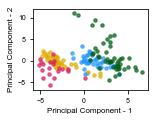

In [87]:
# Figure 4B
# Repackage the all-data PCA for standalone export

# start with an evocode_list that is without YP10
evocode_listupdate = new_evocode_list.copy(deep = True)
evocode_listupdate['evoEnvt-ploidy'] = evocode_listupdate['evoEnvt']+"-"+evocode_listupdate['ploidy'].map(str)
evocode_listupdate['evoEnvt-ploidy-LP'] = evocode_listupdate['evoEnvt-ploidy']+"-"+evocode_listupdate['LP'].map(str)
# remove the YP10 guys
tentest = evocode_listupdate['evoEnvt'] != 'YP10%D'
evocode_listupdate = evocode_listupdate[tentest]
evocode_listupdate = evocode_listupdate.reset_index(drop=True)

# go through the evocode list and create a column for each fitness at each epoch (AA, NaCl, etc.). Basically,
# just locate the evocode-epoch (e.g., p8-D3) and fill in the appropriate fitness values into each of 5 lists.
# this first one will be without breaking out the RT into 10-30 and 30-50

endtable = evocode_listupdate

for e in np.arange(len(epochind)):
    YPDendlist = []
    YPD37endlist = []
    AAendlist = []
    RTendlist = []
    NaClendlist = []

    for ec in np.arange(len(evocode_listupdate)):
        picked = finaltable.loc[finaltable['evocode-Epoch'] == evocode_listupdate['evocode'][ec]+'-'+epochind['Epoch'][e]]
        picked = picked.reset_index(drop=True)
        YPDendlist = YPDendlist + [picked.loc[0,'s_30_adj']]
        YPD37endlist = YPD37endlist + [picked.loc[0,'s_37_adj']]
        AAendlist = AAendlist + [picked.loc[0,'s_AA_adj']]
        RTendlist = RTendlist + [picked.loc[0,'s_RT_adj']]
        NaClendlist = NaClendlist + [picked.loc[0,'s_NaCl_adj']]

    endtable['30-'+epochind['Epoch'][e]] = YPDendlist
    endtable['37-'+epochind['Epoch'][e]] = YPD37endlist
    endtable['AA-'+epochind['Epoch'][e]] = AAendlist
    endtable['RT-'+epochind['Epoch'][e]] = RTendlist
    endtable['NaCl-'+epochind['Epoch'][e]] = NaClendlist
    
    
# now normalize this endtable data (standardization), since PCA output influenced by scale of data features.
# ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
# Apply normalization with sklearn's StandardScaler. Want it to normalize such that it has a mean of 0, sd of 1,
# Normally distributed.

endfeatures = list(endtable)[6:len(list(endtable))]
norm_endtable = endtable.loc[:,endfeatures].values
norm_endtable = StandardScaler().fit_transform(norm_endtable)

# now re-project data to n principle components
npc_end = 2
pca_end = PCA(n_components = npc_end)
principalcomponents_end = pca_end.fit_transform(norm_endtable)

# look at the variance explained
#print('Explained variation per principal component: {}'.format(pca_end.explained_variance_ratio_))

# plot
pcend_df = pd.DataFrame(data = principalcomponents_end
                       , columns = ['principal component 1', 'principal component 2'])

figm = plt.figure(figsize=(1.5/(pca_end.explained_variance_ratio_[1]/pca_end.explained_variance_ratio_[0]),1.5))
axm = figm.add_subplot(1, 1, 1)

targets = ['YPD-D','YPD+AA-D','YPD(37C)-D','YPD(37C)-H']
newnames = ['YPD','YPD + Acetic acid','YPD, 37°C, Diploid','YPD, 37°C, Haploid']

colors = ['#2497FD', '#025F17', '#E1AB06','#D81B60']
for target, color in zip(targets,colors):
    indicesToKeep = endtable['evoEnvt-ploidy'] == target
    axm.scatter(pcend_df.loc[indicesToKeep, 'principal component 1']
               , pcend_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 12,alpha=0.7)
    
axm.tick_params(axis='both',labelsize=7)
axm.yaxis.set_ticks(np.arange(-5,11,5))

axm.set_xlabel('Principal Component - 1',size=8)
axm.set_ylabel('Principal Component - 2',rotation=90,size=8)

#if removingoutliers == True:
    #plt.savefig('fig6/PCA/4B_threshold_v01.pdf',bbox_inches='tight',dpi=300)
    #plt.savefig('fig6/PCA/4B_threshold_v01.jpg',bbox_inches='tight',dpi=300)
#else:
    #plt.savefig('fig6/PCA/4B_unfiltered_v01.pdf',bbox_inches='tight',dpi=300)
    #plt.savefig('fig6/PCA/4B_unfiltered_v01.jpg',bbox_inches='tight',dpi=300)

# FOR FUTURE REFERENCE (SEE CALLOUTS BELOW), MERGE POP INFO WITH PCEND_DF
fullpcmap = endtable.copy(deep=True)
fullpcmap['principal component 1'] = pcend_df['principal component 1']
fullpcmap['principal component 2'] = pcend_df['principal component 2']

# Get components table
aeorder = ['30C','37C','Ac ac','21C','NaCl']
compon = pd.DataFrame(pca_end.components_).T
compon.insert(0,'generation-environment',"")
myind = 0
for g in np.arange(len(epochind)):
    for ae in np.arange(len(aeorder)):
        compon.at[myind,'generation-environment'] = epochind['Epoch'][g]+'-'+aeorder[ae]
        myind=myind+1
compon = compon.rename(columns={0:'Contribution to PC1',1:'Contribution to PC2'})



if removingoutliers == True:
    export_csv = fullpcmap.to_csv('20210623_full-endtable_threshold.csv',index=True,header=True)
    export_csv = compon.to_csv('20210623_full-componentstable_threshold.csv',index=True,header=True)
else:
    export_csv = fullpcmap.to_csv('20210623_full-endtable_unfiltered.csv',index=True,header=True)
    export_csv = compon.to_csv('20210623_full-componentstable_unfiltered.csv',index=True,header=True)
    


### Figure 4C

In [ ]:
# Figure 4C
# Callout populations

# create a list of values specifically for one evocode at a time

targets = ['30','AA','37','RT','NaCl']
newnames = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']
colors = ['#2497FD', '#025F17', '#E1AB06','#6B2E58','#A48DE2']

callout_list = ['p6-H7','p1-D5','p3-D8','p8-G3',
                'p6-C8','p4-E6','p7-A7','p8-C8']

fig,ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(3*1.7,2.2))
#fig.subplots_adust()

coords = [[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3]]

for i in np.arange(len(callout_list)):
    temp = finaltable.loc[(finaltable['evocode'] == callout_list[i])].copy(deep=True).sort_values(by='Epoch').reset_index(drop=True)
    homeenv = envts[evoenvs.index(temp.loc[0,'evoEnvt'])]
    homeevo = temp.loc[0,'evoEnvt']
    for e in np.arange(len(envts)):
        if envts[e] == homeenv:
            ax[coords[i][0]][coords[i][1]].errorbar(temp['Epoch'],temp['s_'+envts[e]+'_adj'],xerr=None,yerr=temp['stderr(s)_'+envts[e]],c=colors[e])
            if temp.loc[0,'ploidy'] == 'H':
                plt.setp(ax[coords[i][0]][coords[i][1]].spines.values(),color='#D81B60',lw=1.25,alpha=0.7)
                plt.setp([ax[coords[i][0]][coords[i][1]].get_xticklines(),ax[coords[i][0]][coords[i][1]].get_yticklines()],color='#D81B60')
            else:
                plt.setp(ax[coords[i][0]][coords[i][1]].spines.values(),color=colors[e],lw=1.25,alpha=0.7)
                plt.setp([ax[coords[i][0]][coords[i][1]].get_xticklines(),ax[coords[i][0]][coords[i][1]].get_yticklines()],color=colors[e])
        else:
            ax[coords[i][0]][coords[i][1]].errorbar(temp['Epoch'],temp['s_'+envts[e]+'_adj'],xerr=None,yerr=temp['stderr(s)_'+envts[e]],c=colors[e],linestyle='--')        

    ax[coords[i][0]][coords[i][1]].tick_params(axis='both',labelsize=7)
    ax[coords[i][0]][coords[i][1]].set_yticks([-0.2,-0.1,0,0.1,0.2])
    ax[coords[i][0]][coords[i][1]].set_xticks([0,200,400,600,800,1000])
    ax[coords[i][0]][coords[i][1]].set_xticklabels([0,200,400,600,800,1000],Rotation=45)
    ax[coords[i][0]][coords[i][1]].axhline(y=0,lw=0.5,color='xkcd:grey',zorder=0)
    
    
fig.text(0.52, -0.08, 'Generation', ha='center',size=8)
fig.text(0.04, 0.5, 'Fitness', va='center', rotation='vertical',size=8)

#plt.savefig('fig6/callouts_v01.pdf',bbox_inches='tight',dpi=300)
#plt.show()

### Figure 4D

In [ ]:
# Figure 4D
# Note, the PCA bootstrap generation is not included here

if removingoutliers == True:
    filtering = "thres"
else:
    filtering = "unfil"

fig = plt.figure(figsize=(1.5/(pca_end.explained_variance_ratio_[1]/pca_end.explained_variance_ratio_[0]),1.5))
axclus = fig.add_subplot(1, 1, 1)

#importing data for plotting
true_means = pd.DataFrame(pd.read_csv('for_CWB/%s_true_means.csv' % filtering,delimiter=','))
true_cum = pd.DataFrame(pd.read_csv('for_CWB/%s_true_cum.csv'% filtering,delimiter=','))
bs_low_all = pd.DataFrame(pd.read_csv('for_CWB/%s_bs_low_all.csv'% filtering,delimiter=','))
bs_high_all = pd.DataFrame(pd.read_csv('for_CWB/%s_bs_high_all.csv'% filtering,delimiter=','))
bs_low_cum = pd.DataFrame(pd.read_csv('for_CWB/%s_bs_low_cum.csv'% filtering,delimiter=','))
bs_high_cum = pd.DataFrame(pd.read_csv('for_CWB/%s_bs_high_cum.csv'% filtering,delimiter=','))

########data
#YPD_s30 data
true_YPD_mean = np.array(true_means.YPD)
bs_YPD_lo = np.array(bs_low_all.YPD)
bs_YPD_hi = np.array(bs_high_all.YPD)
bs_YPD_CI = [bs_YPD_lo,bs_YPD_hi]
#YPD_s37 data
true_YPD37_mean = np.array(true_means.YPD37)
bs_YPD37_lo = np.array(bs_low_all.YPD37)
bs_YPD37_hi = np.array(bs_high_all.YPD37)
bs_YPD37_CI = [bs_YPD37_lo,bs_YPD37_hi]
#YPD_s37H data
true_YPD37H_mean = np.array(true_means.YPD37H)
bs_YPD37H_lo = np.array(bs_low_all.YPD37H)
bs_YPD37H_hi = np.array(bs_high_all.YPD37H)
bs_YPD37H_CI = [bs_YPD37H_lo,bs_YPD37H_hi]
#YPD_sAA data
true_YPDAA_mean = np.array(true_means.YPDAA)
bs_YPDAA_lo = np.array(bs_low_all.YPDAA)
bs_YPDAA_hi = np.array(bs_high_all.YPDAA)
bs_YPDAA_CI = [bs_YPDAA_lo,bs_YPDAA_hi]
########################################same for cume data
#YPD_s30 data
true_YPD_cum = np.array(true_cum.YPD)
bs_YPD_lo_c = np.array(bs_low_cum.YPD)
bs_YPD_hi_c = np.array(bs_high_cum.YPD)
bs_YPD_CI_c = [bs_YPD_lo_c,bs_YPD_hi_c]
#YPD_s37 data
true_YPD37_cum = np.array(true_cum.YPD37)
bs_YPD37_lo_c = np.array(bs_low_cum.YPD37)
bs_YPD37_hi_c = np.array(bs_high_cum.YPD37)
bs_YPD37_CI_c = [bs_YPD37_lo_c,bs_YPD37_hi_c]
#YPD_s37H data
true_YPD37H_cum = np.array(true_cum.YPD37H)
bs_YPD37H_lo_c = np.array(bs_low_cum.YPD37H)
bs_YPD37H_hi_c = np.array(bs_high_cum.YPD37H)
bs_YPD37H_CI_c = [bs_YPD37H_lo_c,bs_YPD37H_hi_c]
#YPD_sAA data
true_YPDAA_cum = np.array(true_cum.YPDAA)
bs_YPDAA_lo_c = np.array(bs_low_cum.YPDAA)
bs_YPDAA_hi_c = np.array(bs_high_cum.YPDAA)
bs_YPDAA_CI_c = [bs_YPDAA_lo_c,bs_YPDAA_hi_c]

#setting up plot layout
epoch = ["0","200","400","600","800","1000"]
cum = ["all"]
epoch_array = np.array(epoch)
cum_array = np.array(cum)
#YPD
axclus.errorbar(epoch_array,true_YPD_mean, linewidth=0.8, yerr=bs_YPD_CI, color='#2497FD', label=None,fmt='o',ms=5,linestyle='-')
#YPD cumulative
axclus.errorbar(cum_array, true_YPD_cum, linewidth=0.8, yerr=bs_YPD_CI_c, color='#2497FD', label=None,fmt='o',ms=5,linestyle='-')
#YPD AA
axclus.errorbar(epoch_array,true_YPDAA_mean, linewidth=0.8, yerr=bs_YPDAA_CI, color='#025F17', label=None,fmt='o',ms=5,linestyle='-')
#YPD AA  cumulative
axclus.errorbar(cum_array, true_YPDAA_cum, linewidth=0.8, yerr=bs_YPDAA_CI_c, color='#025F17', label=None,fmt='o',ms=5,linestyle='-')
#YPD 37
axclus.errorbar(epoch_array,true_YPD37_mean, linewidth=0.8, yerr=bs_YPD37_CI, color='#E1AB06', label=None,fmt='o',ms=5,linestyle='-')
#YPD 37 cumulative
axclus.errorbar(cum_array, true_YPD37_cum, linewidth=0.8, yerr=bs_YPD37_CI_c, color='#E1AB06', label=None,fmt='o',ms=5,linestyle='-')
#YPD HAP
axclus.errorbar(epoch_array,true_YPD37H_mean, linewidth=0.8, yerr=bs_YPD37H_CI, color='#D81B60', label=None,fmt='o',ms=5,linestyle='-')
#YPD HAP cumulative
axclus.errorbar(cum_array, true_YPD37H_cum, linewidth=0.8, yerr=bs_YPD37H_CI_c, color='#D81B60', label=None,fmt='o',ms=5,linestyle='-')

axclus.set_ylabel('\n'.join(wrap('Mean clustering coefficient',20)),size=8)
axclus.set_xlabel("Generation", size=8)
axclus.tick_params(direction='out', length=3, width=1)
plt.setp(axclus.get_xticklabels(), fontsize=7)
plt.setp(axclus.get_yticklabels(), fontsize=7)
axclus.set_ylim((0,5))

#if removingoutlers == True:
#    plt.savefig('fig6/PCA/4C_threshold_v01.pdf',bbox_inches='tight',dpi=300)
#    plt.savefig('fig6/PCA/4C_threshold_v01.jpg',bbox_inches='tight',dpi=300)
#else:
#    plt.savefig('fig6/PCA/4C_unfiltered_v01.pdf',bbox_inches='tight',dpi=300)
#    plt.savefig('fig6/PCA/4C_unfiltered_v01.jpg',bbox_inches='tight',dpi=300)

plt.show()


### Figure 4 supplemental 2 and 3

In [14]:
# Generate the datasets for supp 3

# start with an evocode_list that is without YP10
evocode_listupdate = new_evocode_list.copy(deep = True)
evocode_listupdate['evoEnvt-ploidy'] = evocode_listupdate['evoEnvt']+"-"+evocode_listupdate['ploidy'].map(str)
evocode_listupdate['evoEnvt-ploidy-LP'] = evocode_listupdate['evoEnvt-ploidy']+"-"+evocode_listupdate['LP'].map(str)
# remove the YP10 guys
tentest = evocode_listupdate['evoEnvt'] != 'YP10%D'
evocode_listupdate = evocode_listupdate[tentest]
evocode_listupdate = evocode_listupdate.reset_index(drop=True)

# go through the evocode list and create a column for each fitness at each epoch (AA, NaCl, etc.). Basically,
# just locate the evocode-epoch (e.g., p8-D3) and fill in the appropriate fitness values into each of 5 lists.

endtable = evocode_listupdate

for e in np.arange(len(epochind)):
    YPDendlist = []
    YPD37endlist = []
    AAendlist = []
    RTendlist = []
    NaClendlist = []

    for ec in np.arange(len(evocode_listupdate)):
        picked = finaltable.loc[finaltable['evocode-Epoch'] == evocode_listupdate['evocode'][ec]+'-'+epochind['Epoch'][e]]
        picked = picked.reset_index(drop=True)
        YPDendlist = YPDendlist + [picked.loc[0,'s_30_adj']]
        YPD37endlist = YPD37endlist + [picked.loc[0,'s_37_adj']]
        AAendlist = AAendlist + [picked.loc[0,'s_AA_adj']]
        RTendlist = RTendlist + [picked.loc[0,'s_RT_adj']]
        NaClendlist = NaClendlist + [picked.loc[0,'s_NaCl_adj']]

    endtable['30-'+epochind['Epoch'][e]] = YPDendlist
    endtable['37-'+epochind['Epoch'][e]] = YPD37endlist
    endtable['AA-'+epochind['Epoch'][e]] = AAendlist
    endtable['RT-'+epochind['Epoch'][e]] = RTendlist
    endtable['NaCl-'+epochind['Epoch'][e]] = NaClendlist
    
# now normalize this endtable data (standardization), since PCA output influenced by scale of data features.
# ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
# Apply normalization with sklearn's StandardScaler. Want it to normalize such that it has a mean of 0, sd of 1,
# Normally distributed.

endfeatures = list(endtable)[6:len(list(endtable))]
norm_endtable = endtable.loc[:,endfeatures].values
norm_endtable = StandardScaler().fit_transform(norm_endtable)

# now re-project data to n principle components
npc_end = 2
pca_end = PCA(n_components = npc_end)
principalcomponents_end = pca_end.fit_transform(norm_endtable)

# look at the variance explained
#print('Explained variation per principal component: {}'.format(pca_end.explained_variance_ratio_))

pcend_df = pd.DataFrame(data = principalcomponents_end
                       , columns = ['principal component 1', 'principal component 2'])

endtable['principal component 1'] = pcend_df['principal component 1']
endtable['principal component 2'] = pcend_df['principal component 2']
endtable['Epoch'] = 'all'

# First, get the error bars (95% CIs) using bootstrapped s data

PC1_boot = []
PC2_boot = []
PC1sum_boot = []
PC2sum_boot = []

nboots = 100

for n in np.arange(nboots):
    # start with an evocode_list that is without YP10
    evocode_listupdate_boot = new_evocode_list.copy(deep = True)
    evocode_listupdate_boot['evoEnvt-ploidy'] = evocode_listupdate_boot['evoEnvt']+"-"+evocode_listupdate_boot['ploidy'].map(str)
    evocode_listupdate_boot['evoEnvt-ploidy-LP'] = evocode_listupdate_boot['evoEnvt-ploidy']+"-"+evocode_listupdate_boot['LP'].map(str)
    
    # remove the YP10 guys
    tentest = evocode_listupdate_boot['evoEnvt'] != 'YP10%D'
    evocode_listupdate_boot = evocode_listupdate_boot[tentest]
    evocode_listupdate_boot = evocode_listupdate_boot.reset_index(drop=True)
    
    # Import bootstrapped s values
    if removingoutliers == True:
        boot_all = pd.read_csv("bootstraps/s/20200509_final_s_table_threshold_"+str(n)+"_wadj.csv")
    else:
        boot_all = pd.read_csv("bootstraps/s/20200509_final_s_table_unfiltered_"+str(n)+"_wadj.csv")
    
    endtable_boot = evocode_listupdate_boot.copy(deep=True)

    for e in np.arange(len(epochind)):
        YPDendlist = []
        YPD37endlist = []
        AAendlist = []
        RTendlist = []
        NaClendlist = []

        for ec in np.arange(len(evocode_listupdate_boot)):
            picked = boot_all.loc[boot_all['evocode-Epoch'] == evocode_listupdate_boot['evocode'][ec]+'-'+epochind['Epoch'][e]]
            picked = picked.reset_index(drop=True)
            YPDendlist = YPDendlist + [picked.loc[0,'s_30_adj']]
            YPD37endlist = YPD37endlist + [picked.loc[0,'s_37_adj']]
            AAendlist = AAendlist + [picked.loc[0,'s_AA_adj']]
            RTendlist = RTendlist + [picked.loc[0,'s_RT_adj']]
            NaClendlist = NaClendlist + [picked.loc[0,'s_NaCl_adj']]

        endtable_boot['30-'+epochind['Epoch'][e]] = YPDendlist
        endtable_boot['37-'+epochind['Epoch'][e]] = YPD37endlist
        endtable_boot['AA-'+epochind['Epoch'][e]] = AAendlist
        endtable_boot['RT-'+epochind['Epoch'][e]] = RTendlist
        endtable_boot['NaCl-'+epochind['Epoch'][e]] = NaClendlist


    # now normalize this endtable data (standardization), since PCA output influenced by scale of data features.
    # ref: https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
    # Apply normalization with sklearn's StandardScaler. Want it to normalize such that it has a mean of 0, sd of 1,
    # Normally distributed.

    endfeatures_boot = list(endtable_boot)[6:len(list(endtable_boot))]
    norm_endtable_boot = endtable_boot.loc[:,endfeatures_boot].values
    norm_endtable_boot = StandardScaler().fit_transform(norm_endtable_boot)

    # now re-project data to 2 principle components
    npc_end = 2
    pca_end_boot = PCA(n_components = npc_end)
    principalcomponents_end_boot = pca_end_boot.fit_transform(norm_endtable_boot)
    
    pceig_boot = pd.DataFrame(pca_end_boot.components_,columns=endfeatures_boot)
    pceig_boot = pceig_boot.T
    pceig_boot = pceig_boot.reset_index(drop=False)
    pceig_boot = pceig_boot.rename(columns={"index":"endfeature",0:"PC1", 1:"PC2"})
    pceig_boot['envt'] = ""
    pceig_boot['epoch'] = ""
    for i in np.arange(len(pceig_boot)):
        pceig_boot.at[i,'envt'] = pceig_boot.loc[i,'endfeature'][0:pceig_boot.loc[i,'endfeature'].find('-')]
        pceig_boot.at[i,'epoch'] = pceig_boot.loc[i,'endfeature'][pceig_boot.loc[i,'endfeature'].find('-')+1:len(pceig_boot.loc[i,'endfeature'])]
    
    pceig_boot['PC1plus'] = abs(pceig_boot['PC1'])
    pceig_boot['PC2plus'] = abs(pceig_boot['PC2'])

    sumplotter_boot = pd.DataFrame(columns=['Epoch','PC1sum','PC2sum'])
    sumplotter_boot['Epoch'] = [0,200,400,600,800,1000]
    for epoch in np.arange(len(epochind)):
        sumplotter_boot.at[epoch,'PC1sum'] = sum(pceig_boot.loc[(pceig_boot['epoch'] == epochind['Epoch'][epoch])]['PC1plus'])
        sumplotter_boot.at[epoch,'PC2sum'] = sum(pceig_boot.loc[(pceig_boot['epoch'] == epochind['Epoch'][epoch])]['PC2plus'])
    sumplotter_boot['PC1sum'] = sumplotter_boot['PC1sum']/sum(sumplotter_boot['PC1sum'])
    sumplotter_boot['PC2sum'] = sumplotter_boot['PC2sum']/sum(sumplotter_boot['PC2sum'])
    
    PC1_boot = PC1_boot + [pceig_boot['PC1'].values.tolist()]
    PC2_boot = PC2_boot + [pceig_boot['PC2'].values.tolist()]
    PC1sum_boot = PC1sum_boot + [sumplotter_boot['PC1sum'].values.tolist()]
    PC2sum_boot = PC2sum_boot + [sumplotter_boot['PC2sum'].values.tolist()]
    
# For the bootstrapped datasets, integrate things into CI estimates
PC1_boot_stats = []
PC2_boot_stats = []
PC1sum_boot_stats = []
PC2sum_boot_stats = []

for i in np.arange(len(PC1_boot[0])):
    b1 = []
    b2 = []
    for n in np.arange(nboots):
        b1 = b1 + [PC1_boot[n][i]]
        b2 = b2 + [PC2_boot[n][i]]
    ql1 = np.quantile(b1,0.025)
    qu1 = np.quantile(b1,0.975)
    mean1 = np.mean(b1)
    ql2 = np.quantile(b2,0.025)
    qu2 = np.quantile(b2,0.975)
    mean2 = np.mean(b2)
    PC1_boot_stats = PC1_boot_stats + [[ql1,qu1,mean1]]
    PC2_boot_stats = PC2_boot_stats + [[ql2,qu2,mean2]]

for j in np.arange(len(PC1sum_boot[0])):
    s1 = []
    s2 = []
    for n in np.arange(nboots):
        s1 = s1 + [PC1sum_boot[n][j]]
        s2 = s2 + [PC2sum_boot[n][j]]
    sql1 = np.quantile(s1,0.025)
    squ1 = np.quantile(s1,0.975)
    smean1 = np.mean(s1)
    sql2 = np.quantile(s2,0.025)
    squ2 = np.quantile(s2,0.975)
    smean2 = np.mean(s2)
    PC1sum_boot_stats = PC1sum_boot_stats + [[sql1,squ1,smean1]]
    PC2sum_boot_stats = PC2sum_boot_stats + [[sql2,squ2,smean2]]

# each row corresponds to a feature (environment-epoch)
PC1_boot_stats = pd.DataFrame(data=PC1_boot_stats,columns=['PC1-LQ','PC1-UQ','PC1-mean'])
PC2_boot_stats = pd.DataFrame(data=PC2_boot_stats,columns=['PC2-LQ','PC2-UQ','PC2-mean'])
# each row corresponds to a timepoint (epoch)
PC1sum_boot_stats = pd.DataFrame(data=PC1sum_boot_stats,columns=['PC1-LQ','PC1-UQ','PC1-mean'])
PC2sum_boot_stats = pd.DataFrame(data=PC2sum_boot_stats,columns=['PC2-LQ','PC2-UQ','PC2-mean'])

# Now, extract the principal component eigenvalues in an intelligible way
pceig = pd.DataFrame(pca_end.components_,columns=endfeatures)
pceig = pceig.T
pceig = pceig.reset_index(drop=False)
pceig = pceig.rename(columns={"index":"endfeature",0:"PC1", 1:"PC2"})
pceig['envt'] = ""
pceig['epoch'] = ""
for i in np.arange(len(pceig)):
    pceig.at[i,'envt'] = pceig.loc[i,'endfeature'][0:pceig.loc[i,'endfeature'].find('-')]
    pceig.at[i,'epoch'] = pceig.loc[i,'endfeature'][pceig.loc[i,'endfeature'].find('-')+1:len(pceig.loc[i,'endfeature'])]

# Now plot the importance of each epoch to determining PCs over time
pceig['PC1plus'] = abs(pceig['PC1'])
pceig['PC2plus'] = abs(pceig['PC2'])

sumplotter = pd.DataFrame(columns=['Epoch','PC1sum','PC2sum'])
sumplotter['Epoch'] = [0,200,400,600,800,1000]
for epoch in np.arange(len(epochind)):
    sumplotter.at[epoch,'PC1sum'] = sum(pceig.loc[(pceig['epoch'] == epochind['Epoch'][epoch])]['PC1plus'])
    sumplotter.at[epoch,'PC2sum'] = sum(pceig.loc[(pceig['epoch'] == epochind['Epoch'][epoch])]['PC2plus'])
sumplotter['PC1sum'] = sumplotter['PC1sum']/sum(sumplotter['PC1sum'])
sumplotter['PC2sum'] = sumplotter['PC2sum']/sum(sumplotter['PC2sum'])

# Add the bootstrapped 95% CIs to the dataframes
pceig = pceig.join(PC1_boot_stats[['PC1-LQ','PC1-UQ','PC1-mean']])
pceig = pceig.join(PC2_boot_stats[['PC2-LQ','PC2-UQ','PC2-mean']])
pceig['PC1-LE'] = pceig['PC1-mean'] - pceig['PC1-LQ']
pceig['PC1-UE'] = pceig['PC1-UQ'] - pceig['PC1-mean']
pceig['PC2-LE'] = pceig['PC2-mean'] - pceig['PC2-LQ']
pceig['PC2-UE'] = pceig['PC2-UQ'] - pceig['PC2-mean']
pceig['PC1meandiff'] = pceig['PC1'] - pceig['PC1-mean']
pceig['PC2meandiff'] = pceig['PC2'] - pceig['PC2-mean']

sumplotter = sumplotter.join(PC1sum_boot_stats[['PC1-LQ','PC1-UQ','PC1-mean']])
sumplotter = sumplotter.join(PC2sum_boot_stats[['PC2-LQ','PC2-UQ','PC2-mean']])
sumplotter['PC1-LE'] = sumplotter['PC1-mean'] - sumplotter['PC1-LQ']
sumplotter['PC1-UE'] = sumplotter['PC1-UQ'] - sumplotter['PC1-mean']
sumplotter['PC2-LE'] = sumplotter['PC2-mean'] - sumplotter['PC2-LQ']
sumplotter['PC2-UE'] = sumplotter['PC2-UQ'] - sumplotter['PC2-mean']
sumplotter['PC1meandiff'] = sumplotter['PC1sum'] - sumplotter['PC1-mean']
sumplotter['PC2meandiff'] = sumplotter['PC2sum'] - sumplotter['PC2-mean']



In [15]:
# Now generate the dataset for supp 2

# First, get the errorbars for plotting the PC contributions
PC1conlist = []
PC2conlist = []
varlist = []

nboots = 100

for n in np.arange(nboots):
    # start with an evocode_list that is without YP10
    evocode_listupdate_boot = new_evocode_list.copy(deep = True)
    evocode_listupdate_boot['evoEnvt-ploidy'] = evocode_listupdate_boot['evoEnvt']+"-"+evocode_listupdate_boot['ploidy'].map(str)
    evocode_listupdate_boot['evoEnvt-ploidy-LP'] = evocode_listupdate_boot['evoEnvt-ploidy']+"-"+evocode_listupdate_boot['LP'].map(str)
    # remove the YP10 guys
    tentest = evocode_listupdate_boot['evoEnvt'] != 'YP10%D'
    evocode_listupdate_boot = evocode_listupdate_boot[tentest]
    evocode_listupdate_boot = evocode_listupdate_boot.reset_index(drop=True)
    
    if removingoutliers == True:
        boot_all = pd.read_csv("bootstraps/s/20200509_final_s_table_threshold_"+str(n)+"_wadj.csv")
    else:
        boot_all = pd.read_csv("bootstraps/s/20200509_final_s_table_unfiltered_"+str(n)+"_wadj.csv")
    
    endtable_boot = evocode_listupdate_boot.copy(deep=True)

    for e in np.arange(len(epochind)):
        YPDendlist = []
        YPD37endlist = []
        AAendlist = []
        RTendlist = []
        NaClendlist = []

        for ec in np.arange(len(evocode_listupdate)):
            picked = boot_all.loc[boot_all['evocode-Epoch'] == evocode_listupdate_boot['evocode'][ec]+'-'+epochind['Epoch'][e]]
            picked = picked.reset_index(drop=True)
            YPDendlist = YPDendlist + [picked.loc[0,'s_30_adj']]
            YPD37endlist = YPD37endlist + [picked.loc[0,'s_37_adj']]
            AAendlist = AAendlist + [picked.loc[0,'s_AA_adj']]
            RTendlist = RTendlist + [picked.loc[0,'s_RT_adj']]
            NaClendlist = NaClendlist + [picked.loc[0,'s_NaCl_adj']]

        endtable_boot['30-'+epochind['Epoch'][e]] = YPDendlist
        endtable_boot['37-'+epochind['Epoch'][e]] = YPD37endlist
        endtable_boot['AA-'+epochind['Epoch'][e]] = AAendlist
        endtable_boot['RT-'+epochind['Epoch'][e]] = RTendlist
        endtable_boot['NaCl-'+epochind['Epoch'][e]] = NaClendlist
        
    PC1cons = []
    PC2cons = []
    varl = []

    for e in np.arange(len(epochind)):
        specendtable_boot = endtable_boot[list(endtable_boot)[:6]+list(endtable_boot)[6+5*e:11+5*e]].copy(deep=True)

        endfeatures = list(specendtable_boot)[6:len(list(specendtable_boot))]
        norm_endtable_boot = specendtable_boot.loc[:,endfeatures].values
        norm_endtable_boot = StandardScaler().fit_transform(norm_endtable_boot)

        # now re-project data to n principle components
        npc_end = 2
        pca_end_boot = PCA(n_components = npc_end)
        principalcomponents_end_boot = pca_end_boot.fit_transform(norm_endtable_boot)

        pcend_df_boot = pd.DataFrame(data = principalcomponents_end_boot
                               , columns = ['principal component 1', 'principal component 2'])

        specendtable_boot['principal component 1'] = pcend_df_boot['principal component 1']
        specendtable_boot['principal component 2'] = pcend_df_boot['principal component 2']
        specendtable_boot['Epoch'] = float(epochind['Epoch'][e])

        thesecomp_boot = pd.DataFrame(data=pca_end_boot.components_)
        thesecomp_boot = thesecomp_boot.rename(columns={0:"30",1:"37", 2:"AA",3:"RT",4:"NaCl"})
        thesecomp_boot = thesecomp_boot.T
        thesecomp_boot = thesecomp_boot.rename(columns={0:'PC1',1:'PC2'})
        thesecomp_boot['Epoch'] = float(epochind['Epoch'][e])
        thesecomp_boot = thesecomp_boot.reset_index()
        thesecomp_boot = thesecomp_boot.rename(columns={'index':'envt'})
        
        pca_boot = PCA().fit(norm_endtable_boot)
        pca_boot_var = pca_boot.explained_variance_ratio_
        thesevar_boot = pd.DataFrame(data=pca_boot_var)
        thesevar_boot = thesevar_boot.rename(columns={0:'varexp'}).reset_index()
        thesevar_boot = thesevar_boot.rename(columns={'index':'PC'})
        thesevar_boot['Epoch'] = float(epochind['Epoch'][e])
        
        PC1cons = PC1cons + [thesecomp_boot['PC1'].values.tolist()]
        PC2cons = PC2cons + [thesecomp_boot['PC2'].values.tolist()]
        varl = varl + [thesevar_boot['varexp'].values.tolist()]
    
    PC1conlist = PC1conlist + [PC1cons]
    PC2conlist = PC2conlist + [PC2cons]
    varlist = varlist + [varl]

# For each epoch in the bootstrapped list, go through and flip things to be same orientation, for reasonable error bars
PC1conlist_work = PC1conlist
PC2conlist_work = PC2conlist
varlist_work = varlist

for n in np.arange(len(PC1conlist_work)):
    for e in np.arange(len(epochind)):
        # Make 30 always positive for PC1
        if PC1conlist_work[n][e][0] < 0:
            PC1conlist_work[n][e] = [i * -1 for i in PC1conlist_work[n][e]]
        
        # Make AA always positive for PC2
        if PC2conlist_work[n][e][2] < 0:
            PC2conlist_work[n][e] = [i * -1 for i in PC2conlist_work[n][e]]

# For the bootstrapped datasets, integrate into CI estimates
LQUQ1 = []
LQUQ2 = []
LQUQv = []
for e in np.arange(len(epochind)):
    eLQUQ1 = []
    eLQUQ2 = []
    eLQUQv = []
    for env in np.arange(len(envts)):
        longlist1 = []
        longlist2 = []
        for n in np.arange(len(PC1conlist_work)):
            longlist1 = longlist1 + [PC1conlist_work[n][e][env]]
            longlist2 = longlist2 + [PC2conlist_work[n][e][env]]
        ql1 = np.quantile(longlist1,0.025)
        qu1 = np.quantile(longlist1,0.975)
        mean1 = np.mean(longlist1)
        ql2 = np.quantile(longlist2,0.025)
        qu2 = np.quantile(longlist2,0.975)
        mean2 = np.mean(longlist2)
        eLQUQ1 = eLQUQ1 + [[ql1,qu1,mean1]]
        eLQUQ2 = eLQUQ2 + [[ql2,qu2,mean2]]
    LQUQ1 = LQUQ1 + [eLQUQ1]
    LQUQ2 = LQUQ2 + [eLQUQ2]
    
    for var in np.arange(5):
        longlistv = []
        for n in np.arange(len(varlist_work)):
            longlistv = longlistv + [varlist_work[n][e][var]]
        qlv = np.quantile(longlistv,0.025)
        quv = np.quantile(longlistv,0.975)
        meanv = np.mean(longlistv)
        eLQUQv = eLQUQv + [[qlv,quv,meanv]]
    LQUQv = LQUQv + [eLQUQv]
    
LQUQt = [LQUQ1]+[LQUQ2]+[LQUQv]

# make LQ, UQ in format that can be appended to eig_var later

PC1holderL = pd.DataFrame(columns=['PC1-30LQ','PC1-37LQ','PC1-AALQ','PC1-RTLQ','PC1-NaClLQ'])
PC2holderL = pd.DataFrame(columns=['PC2-30LQ','PC2-37LQ','PC2-AALQ','PC2-RTLQ','PC2-NaClLQ'])
PC1holderU = pd.DataFrame(columns=['PC1-30UQ','PC1-37UQ','PC1-AAUQ','PC1-RTUQ','PC1-NaClUQ'])
PC2holderU = pd.DataFrame(columns=['PC2-30UQ','PC2-37UQ','PC2-AAUQ','PC2-RTUQ','PC2-NaClUQ'])
PC1holderM = pd.DataFrame(columns=['PC1-30m','PC1-37m','PC1-AAm','PC1-RTm','PC1-NaClm'])
PC2holderM = pd.DataFrame(columns=['PC2-30m','PC2-37m','PC2-AAm','PC2-RTm','PC2-NaClm'])
varholderL = pd.DataFrame(columns=['var1LQ','var2LQ','var3LQ','var4LQ','var5LQ'])
varholderU = pd.DataFrame(columns=['var1UQ','var2UQ','var3UQ','var4UQ','var5UQ'])
varholderM = pd.DataFrame(columns=['var1m','var2m','var3m','var4m','var5m'])

vcolsL = ['var1LQ','var2LQ','var3LQ','var4LQ','var5LQ']
vcolsU = ['var1UQ','var2UQ','var3UQ','var4UQ','var5UQ']
vcolsM = ['var1m','var2m','var3m','var4m','var5m']
pccols1L = ['PC1-30LQ','PC1-37LQ','PC1-AALQ','PC1-RTLQ','PC1-NaClLQ']
pccols1U = ['PC1-30UQ','PC1-37UQ','PC1-AAUQ','PC1-RTUQ','PC1-NaClUQ']
pccols1M = ['PC1-30m','PC1-37m','PC1-AAm','PC1-RTm','PC1-NaClm']
pccols2L = ['PC2-30LQ','PC2-37LQ','PC2-AALQ','PC2-RTLQ','PC2-NaClLQ']
pccols2U = ['PC2-30UQ','PC2-37UQ','PC2-AAUQ','PC2-RTUQ','PC2-NaClUQ']
pccols2M = ['PC2-30m','PC2-37m','PC2-AAm','PC2-RTm','PC2-NaClm']


for e in np.arange(len(epochind)):
    for pc in np.arange(2):
        if pc == 0:
            PCL = pd.DataFrame(data=LQUQt[pc][e],index=pccols1L).T
            PCL = PCL.iloc[0,:]
            PC1holderL = PC1holderL.append(PCL[pccols1L]).reset_index(drop=True)
            PCU = pd.DataFrame(data=LQUQt[pc][e],index=pccols1U).T
            PCU = PCU.iloc[1,:]
            PC1holderU = PC1holderU.append(PCU[pccols1U]).reset_index(drop=True)
            PCm = pd.DataFrame(data=LQUQt[pc][e],index=pccols1M).T
            PCm = PCm.iloc[2,:]
            PC1holderM = PC1holderM.append(PCm[pccols1M]).reset_index(drop=True)
        else:
            PCL = pd.DataFrame(data=LQUQt[pc][e],index=pccols2L).T
            PCL = PCL.iloc[0,:]
            PC2holderL = PC2holderL.append(PCL[pccols2L]).reset_index(drop=True)
            PCU = pd.DataFrame(data=LQUQt[pc][e],index=pccols2U).T
            PCU = PCU.iloc[1,:]
            PC2holderU = PC2holderU.append(PCU[pccols2U]).reset_index(drop=True)
            PCm = pd.DataFrame(data=LQUQt[pc][e],index=pccols2M).T
            PCm = PCm.iloc[2,:]
            PC2holderM = PC2holderM.append(PCm[pccols2M]).reset_index(drop=True)
    vL = pd.DataFrame(data=LQUQt[2][e],index=vcolsL).T
    vL = vL.iloc[0,:]
    varholderL = varholderL.append(vL[vcolsL]).reset_index(drop=True)
    vU = pd.DataFrame(data=LQUQt[2][e],index=vcolsU).T
    vU = vU.iloc[1,:]
    varholderU = varholderU.append(vU[vcolsU]).reset_index(drop=True)
    vm = pd.DataFrame(data=LQUQt[2][e],index=vcolsM).T
    vm = vm.iloc[2,:]
    varholderM = varholderM.append(vm[vcolsM]).reset_index(drop=True)

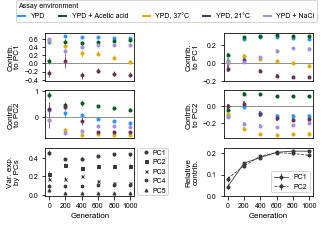

In [16]:
# Do figure 4 supplements 2 and 3

fig1 = plt.figure(constrained_layout=False,figsize=(4.8,3))
gs1 = fig1.add_gridspec(1,2,wspace=1,hspace=0.3)

# This sets up all the different parts of the figure
gs10 = gs1[0,0].subgridspec(3,1)
gs12 = gs1[0,1].subgridspec(3,1)

aenames = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']
envtcolors = ['#2497FD', '#025F17', '#E1AB06','#6B2E58','#A48DE2']

axstats0 = fig1.add_subplot(gs10[0,0])
for envt in np.arange(len(envts)):
    axstats0.errorbar(list(epochind['Epoch'].astype(float)),
                      PC1holderM['PC1-'+envts[envt]+'m'],
                      yerr=[PC1holderM['PC1-'+envts[envt]+'m'] - PC1holderL['PC1-'+envts[envt]+'LQ'],
                            PC1holderU['PC1-'+envts[envt]+'UQ'] - PC1holderM['PC1-'+envts[envt]+'m']],
                      color=envtcolors[envt],marker='.',linestyle='None',linewidth=0.8)
    axstats0.axhline(y=0,linewidth=0.75,color='xkcd:grey')

axstats1 = fig1.add_subplot(gs10[1,0])
for envt in np.arange(len(envts)):
    axstats1.errorbar(list(epochind['Epoch'].astype(float)),
                      PC2holderM['PC2-'+envts[envt]+'m'],
                      yerr=[PC2holderM['PC2-'+envts[envt]+'m'] - PC2holderL['PC2-'+envts[envt]+'LQ'],
                            PC2holderU['PC2-'+envts[envt]+'UQ'] - PC2holderM['PC2-'+envts[envt]+'m']],
                      color=envtcolors[envt],marker='.',linestyle='None',linewidth=0.8)
    axstats1.axhline(y=0,linewidth=0.75,color='xkcd:grey')

axstats2 = fig1.add_subplot(gs10[2,0])
markers = ['o','s','x','h','^']
for i in np.arange(1,6):
    axstats2.errorbar(list(epochind['Epoch'].astype(float)),varholderM['var'+str(i)+'m'],
                      yerr=[varholderM['var'+str(i)+'m'] - varholderL['var'+str(i)+'LQ'],
                            varholderU['var'+str(i)+'UQ'] - varholderM['var'+str(i)+'m']],
                      marker=markers[i-1],markersize=3,color='xkcd:dark grey',
                      #linestyle='dashed', # For v01
                      linestyle='None', # For v02
                      linewidth=0.8)

axstats0.tick_params(axis='both',labelsize=7)
axstats1.tick_params(axis='both',labelsize=7)
axstats2.tick_params(axis='both',labelsize=7)

axstats0.xaxis.set_ticks(np.arange(0,1200,200))
axstats1.xaxis.set_ticks(np.arange(0,1200,200))
axstats2.xaxis.set_ticks(np.arange(0,1200,200))

axstats0.yaxis.set_ticks(np.arange(-.4,.7,.2))

axstats0.axes.xaxis.set_visible(False)
axstats1.axes.xaxis.set_visible(False)

axstats0.yaxis.set_label_coords(-0.28, 0.5)
axstats1.yaxis.set_label_coords(-0.28, 0.5)
axstats2.yaxis.set_label_coords(-0.28, 0.5)

rows = ['Contrib. to PC1','Contrib. to PC2','Var. exp. by PCs']
rows = ['\n'.join(wrap(l, 10)) for l in rows ]

axstats0.set_ylabel(rows[0], rotation=90, size=8)
axstats1.set_ylabel(rows[1], rotation=90, size=8)
axstats2.set_ylabel(rows[2], rotation=90, size=8)

axstats2.set_xlabel("Generation", size=8)

# Add legend
mylw=2
legend_el = [Line2D([0],[0],color=envtcolors[0],label=aenames[0],lw=mylw),
            Line2D([0],[0],color=envtcolors[1],label=aenames[1],lw=mylw),
            Line2D([0],[0],color=envtcolors[2],label=aenames[2],lw=mylw),
            Line2D([0],[0],color=envtcolors[3],label=aenames[3],lw=mylw),
            Line2D([0],[0],color=envtcolors[4],label=aenames[4],lw=mylw)]

myms = 3
legend_elC = [Line2D([0], [0], marker='o',color='xkcd:dark grey', label='PC1', markersize=myms,linestyle='None'),
             Line2D([0], [0], marker='s',color='xkcd:dark grey', label='PC2', markersize=myms,linestyle='None'),
             Line2D([0], [0], marker='x',color='xkcd:dark grey', label='PC3', markersize=myms,linestyle='None'),
             Line2D([0], [0], marker='h',color='xkcd:dark grey', label='PC4', markersize=myms,linestyle='None'),
             Line2D([0], [0], marker='^',color='xkcd:dark grey', label='PC5', markersize=myms,linestyle='None')]

leg1 = fig1.legend(handles=legend_el,handlelength=1,fontsize=7,loc='upper center', ncol=5,borderaxespad=0,title='Assay environment')
leg1._legend_box.align = "left"

leg2 = axstats2.legend(handles=legend_elC,fontsize=7,loc='lower center',
                       ncol=1,bbox_to_anchor=(1.2,-0.05),handletextpad=0,borderpad=0.2)



# ADD THE CUMULATIVE PCA STATS
axcstats0 = fig1.add_subplot(gs12[0,0])
for envt in np.arange(len(envts)):
    temp = pceig.loc[(pceig['envt'] == envts[envt])].reset_index(drop=True)
    axcstats0.errorbar(temp['epoch'],temp['PC1-mean'],yerr=[temp['PC1-LE'],temp['PC1-UE']],color=envtcolors[envt],marker='.',linestyle='None')
    axcstats0.axhline(y=0,linewidth=0.75,color='xkcd:grey')

axcstats1 = fig1.add_subplot(gs12[1,0])
for envt in np.arange(len(envts)):
    temp = pceig.loc[(pceig['envt'] == envts[envt])].reset_index(drop=True)
    axcstats1.errorbar(temp['epoch'],temp['PC2-mean'],yerr=[temp['PC2-LE'],temp['PC2-UE']],color=envtcolors[envt],marker='.',linestyle='None')
    axcstats1.axhline(y=0,linewidth=0.75,color='xkcd:grey')

axcstats2 = fig1.add_subplot(gs12[2,0])
axcstats2.errorbar(temp['epoch'],sumplotter['PC1-mean'],yerr=[sumplotter['PC1-LE'],sumplotter['PC1-UE']],color='xkcd:dark grey',marker='.',linewidth=0.8)
axcstats2.errorbar(temp['epoch'],sumplotter['PC2-mean'],yerr=[sumplotter['PC2-LE'],sumplotter['PC2-UE']],color='xkcd:dark grey',marker='.',linestyle='dashed',linewidth=0.8)
axcstats2.legend(['PC1','PC2'],loc='lower right',fontsize=7)

axcstats0.tick_params(axis='both',labelsize=7)
axcstats1.tick_params(axis='both',labelsize=7)
axcstats2.tick_params(axis='both',labelsize=7)

axcstats2.yaxis.set_ticks(np.arange(0,0.3,0.1))

axcstats0.axes.xaxis.set_visible(False)
axcstats1.axes.xaxis.set_visible(False)

rows = ['Contrib. to PC1','Contrib. to PC2','Relative contrib.']
rows = ['\n'.join(wrap(l, 10)) for l in rows ]

axcstats0.set_ylabel(rows[0], rotation=90, size=8)
axcstats1.set_ylabel(rows[1], rotation=90, size=8)
axcstats2.set_ylabel(rows[2], rotation=90, size=8)

axcstats0.yaxis.set_label_coords(-0.28, 0.5)
axcstats1.yaxis.set_label_coords(-0.28, 0.5)
axcstats2.yaxis.set_label_coords(-0.28, 0.5)

axcstats2.set_xlabel("Generation", size=8)

#if removingoutliers == True:
#    fig1.savefig('fig6/PCA/fig4_b3rd_threshold_v02.pdf',bbox_inches='tight',dpi=3000)
#else:
#    fig1.savefig('fig6/PCA/fig4_b3rd_unfiltered_v02.pdf',bbox_inches='tight',dpi=3000)

plt.show()

## Figure 6

In [ ]:
aenames = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']

# populate the table in which we'll do this work
nonmonsuper = pd.DataFrame(columns=['evocode','plate','evoEnvt','ploidy','assayEnvt',
                                    's0','s0err','sl500','sl500err','sr500','sr500err',
                                    'slfinal','slfinalerr','sfinal','sfinalerr'])

myind = 0

for ec in np.arange(len(new_evocode_list)):
    subt = finaltable.loc[(finaltable['evocode'] == new_evocode_list.loc[ec,'evocode'])]
    for e in np.arange(len(envts)):
        nonmonsuper.at[myind,'evocode'] = new_evocode_list.loc[ec,'evocode']
        nonmonsuper.at[myind,'plate'] = new_evocode_list.loc[ec,'evocode'][1]
        nonmonsuper.at[myind,'evoEnvt'] = new_evocode_list.loc[ec,'evoEnvt']
        nonmonsuper.at[myind,'ploidy'] = new_evocode_list.loc[ec,'ploidy']
        nonmonsuper.at[myind,'assayEnvt'] = envts[e]
        nonmonsuper.at[myind,'s0'] = subt.loc[(subt['Epoch'] == 0),'s_'+envts[e]].reset_index(drop=True)[0]
        nonmonsuper.at[myind,'s0err'] = subt.loc[(subt['Epoch'] == 0),'stderr(s)_'+envts[e]].reset_index(drop=True)[0]          
        nonmonsuper.at[myind,'sl500'] = subt.loc[(subt['Epoch'] == 400),'s_'+envts[e]].reset_index(drop=True)[0]
        nonmonsuper.at[myind,'sl500err'] = subt.loc[(subt['Epoch'] == 400),'stderr(s)_'+envts[e]].reset_index(drop=True)[0]  
        nonmonsuper.at[myind,'sr500'] = subt.loc[(subt['Epoch'] == 600),'s_'+envts[e]].reset_index(drop=True)[0]
        nonmonsuper.at[myind,'sr500err'] = subt.loc[(subt['Epoch'] == 600),'stderr(s)_'+envts[e]].reset_index(drop=True)[0]  
        nonmonsuper.at[myind,'slfinal'] = subt.loc[(subt['Epoch'] == 800),'s_'+envts[e]].reset_index(drop=True)[0]
        nonmonsuper.at[myind,'slfinalerr'] = subt.loc[(subt['Epoch'] == 800),'stderr(s)_'+envts[e]].reset_index(drop=True)[0]  
        nonmonsuper.at[myind,'sfinal'] = subt.loc[(subt['Epoch'] == 1000),'s_'+envts[e]].reset_index(drop=True)[0]
        nonmonsuper.at[myind,'sfinalerr'] = subt.loc[(subt['Epoch'] == 1000),'stderr(s)_'+envts[e]].reset_index(drop=True)[0]
        
        myind = myind + 1

# remove the references
nonmonsuper = nonmonsuper.loc[(nonmonsuper['evoEnvt'] != "YP10%D")].reset_index(drop=True)

# do the easy averaging of epoch 400 and 600 to get gen 500 estimate for all that aren't plate 2
nonmonsuperno2 = nonmonsuper.loc[(nonmonsuper['plate'] != '2')].reset_index(drop=True)
nonmonsuperno2['s500'] = nonmonsuperno2[['sl500','sr500']].mean(axis=1)
nonmonsuperno2['s500err'] = ""
nonmonsuperno2['s500err'] = np.sqrt((nonmonsuperno2['sl500err']**2+nonmonsuperno2['sr500err']**2).astype(float))/2
nonmonsuperno2['s1000'] = nonmonsuperno2['sfinal']
nonmonsuperno2['s1000err'] = nonmonsuperno2['sfinalerr']

# Now do the harder interpolation and extrapolation for plate 2 guys
# Try to do this with weighted averages for the errors -- should be equivalent
# to the interpolation math. Do extrapolation separately
nonmonsuper2 = nonmonsuper.loc[(nonmonsuper['plate'] == '2')].reset_index(drop=True)
nonmonsuper2['s500'] = ''
nonmonsuper2['s500err'] = ''
nonmonsuper2['s1000'] = ''
nonmonsuper2['s1000err'] = ''

for i in np.arange(len(nonmonsuper2)):
    # interpolation
    my_m = (nonmonsuper2.loc[i,'sr500'] - nonmonsuper2.loc[i,'sl500'])/200
    my_b = nonmonsuper2.loc[i,'sl500'] - my_m * 360
    nonmonsuper2.at[i,'s500'] = my_m * 500 + my_b
    
    # for the error, use a different approach, where calculating the midway point is done by multiplying
    # y1 and y2 by two weights respectively (each 1/[abs(x3-x1)/abs(x2-x1)] and 1/[abs(x3-x2)/abs(x2-x1)], respectively).
    # Then divide the sum of those by the sum of the weights. 
    # The weights have no error associated with them.
    
    wt1 = 1/(abs(500-360)/abs(560-360))
    wt2 = 1/(abs(500-560)/abs(560-360))
    nonmonsuper2.at[i,'s500err'] = np.sqrt((wt1*nonmonsuper2.loc[i,'sl500err'])**2+(wt2*nonmonsuper2.loc[i,'sr500err'])**2)/(wt1+wt2)
    
    #extrapolation
    my_m = (nonmonsuper2.loc[i,'sfinal'] - nonmonsuper2.loc[i,'slfinal'])/200
    my_b = nonmonsuper2.loc[i,'slfinal'] - my_m * 760
    nonmonsuper2.at[i,'s1000'] = my_m * 1000 + my_b
    # For the error, just take the error on the final timepoint we have
    nonmonsuper2['s1000err'] = nonmonsuper2['sfinalerr']
    
nonmonsuper = nonmonsuperno2.append(nonmonsuper2).reset_index(drop=True)

nonmonsuper['ds_0-500'] = nonmonsuper['s500'] - nonmonsuper['s0']
nonmonsuper['ds_500-1000'] = nonmonsuper['s1000'] - nonmonsuper['s500']
nonmonsuper['ds_0-500err'] = np.sqrt((nonmonsuper['s0err']**2 + nonmonsuper['s500err']**2).astype(float))
nonmonsuper['ds_500-1000err'] = np.sqrt((nonmonsuper['s500err']**2 + nonmonsuper['s1000err']**2).astype(float))


# catalog how many in each quadrant for each evolution environment, assay environment, and how ambiguous or not
stable = pd.DataFrame()
stable['evoEnvt'] = ""
stable['ploidy'] = ""
stable['assayEnvt'] = ""
for q in np.arange(4):
    stable['Q'+str(q+1)+'-clearcount'] = ""
    stable['Q'+str(q+1)+'-ambcount'] = ""

for p in np.arange(len(ploidies)):
    for ee in np.arange(len(evoenvsno10)):
        temper = nonmonsuper.loc[(nonmonsuper['ploidy'] == ploidies[p]) & (nonmonsuper['evoEnvt'] == evoenvs[ee])].reset_index(drop=True)
        if len(temper) > 0:
            for ae in np.arange(len(envts)):
                t2 = temper.loc[(temper['assayEnvt'] == envts[ae])].reset_index(drop=True)
                q1clear = 0
                q2clear = 0
                q3clear = 0
                q4clear = 0
                q1amb = 0
                q2amb = 0
                q3amb = 0
                q4amb = 0
                for i in np.arange(len(t2)):
                    xco = t2.loc[i,'ds_0-500']
                    xe = t2.loc[i,'ds_0-500err']
                    yco = t2.loc[i,'ds_500-1000']
                    ye = t2.loc[i,'ds_500-1000err']
                    if xco < 0:
                        if yco < 0:
                            if xco + xe >= 0 or yco + ye >= 0:
                                q3amb = q3amb + 1
                            else:
                                q3clear = q3clear + 1
                        else:
                            if xco + xe >= 0 or yco - ye <= 0:
                                q2amb = q2amb + 1
                            else:
                                q2clear = q2clear + 1
                    else:
                        if yco < 0:
                            if xco - xe <= 0 or yco + ye >= 0:
                                q4amb = q4amb + 1
                            else:
                                q4clear = q4clear + 1
                        else:
                            if xco - xe <= 0 or yco - ye <= 0:
                                q1amb = q1amb + 1
                            else:
                                q1clear = q1clear + 1
                stableadd = pd.DataFrame()
                stableadd['evoEnvt'] = ""
                stableadd['ploidy'] = ""
                stableadd['assayEnvt'] = ""
                for q in np.arange(4):
                    stableadd['Q'+str(q+1)+'-clearcount'] = ""
                    stableadd['Q'+str(q+1)+'-ambcount'] = ""
                stableadd.at[0,'evoEnvt'] = evoenvsno10[ee]
                stableadd.at[0,'ploidy'] = ploidies[p]
                stableadd.at[0,'assayEnvt'] = envts[ae]
                stableadd.at[0,'Q1-clearcount'] = q1clear
                stableadd.at[0,'Q1-ambcount'] = q1amb
                stableadd.at[0,'Q2-clearcount'] = q2clear
                stableadd.at[0,'Q2-ambcount'] = q2amb
                stableadd.at[0,'Q3-clearcount'] = q3clear
                stableadd.at[0,'Q3-ambcount'] = q3amb
                stableadd.at[0,'Q4-clearcount'] = q4clear
                stableadd.at[0,'Q4-ambcount'] = q4amb
                stable = stable.append(stableadd).reset_index(drop=True)

stable['clear1-3'] = stable['Q1-clearcount'] + stable['Q3-clearcount']
stable['amb1-3'] = stable['Q1-ambcount'] + stable['Q3-ambcount']
stable['clear2-4'] = stable['Q2-clearcount'] + stable['Q4-clearcount']
stable['amb2-4'] = stable['Q2-ambcount'] + stable['Q4-ambcount']
stable['total'] = stable['clear1-3'] + stable['amb1-3'] + stable['clear2-4'] + stable['amb2-4']


alphaless = 0.5
alphamore = 0.95


# Let's see if we can combine these 2 sub-figures into a bigger FIGURE 5
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7,3), gridspec_kw={'height_ratios': [2,1]},
                         sharex=False, sharey='row')#,constrained_layout=True)

#eenames = ['YPD, n=43','YPD + Acetic acid, n=48','YPD, 37°C, diploid, n=42','YPD, 37°C, haploid, n=20']
eenames = ['YPD','YPD + Acetic acid','YPD, 37°C (dip.)','YPD, 37°C (hap.)']
eecolors = ['#2497FD', '#025F17', '#E1AB06', '#D81B60']
eenames = ['\n'.join(wrap(l, 18)) for l in eenames ]

aecolors = ['#2497FD', '#025F17', '#E1AB06','#6B2E58','#A48DE2']

for ax, col in zip(axes[0,:], eenames):
    ax.set_title(col, size=8,fontweight='bold')

for p in np.arange(len(ploidies)):
    for ee in np.arange(len(evoenvs)-1):
        temper = nonmonsuper.loc[(nonmonsuper['ploidy'] == ploidies[p]) & (nonmonsuper['evoEnvt'] == evoenvs[ee])].reset_index(drop=True)
        if len(temper) > 0:
            if p > 0:
                for ae in np.arange(len(envts)):
                    t2 = temper.loc[(temper['assayEnvt'] == envts[ae])]
                    if ae != ee:
                        axes[0,ee].errorbar(t2['ds_0-500'],t2['ds_500-1000'],xerr=t2['ds_0-500err'],yerr=t2['ds_500-1000err'],
                                      c=aecolors[ae],alpha=alphaless,marker='o',linestyle='None',ms=0,elinewidth=0.6)
            else:
                for ae in np.arange(len(envts)):
                    t2 = temper.loc[(temper['assayEnvt'] == envts[ae])]
                    if ae != ee:
                        axes[0,ee+1].errorbar(t2['ds_0-500'],t2['ds_500-1000'],xerr=t2['ds_0-500err'],yerr=t2['ds_500-1000err'],
                                            c=aecolors[ae],alpha=alphaless,marker='o',linestyle='None',ms=0,elinewidth=0.6)
            
# now overlay the home environment ones
for p in np.arange(len(ploidies)):
    for ee in np.arange(len(evoenvs)-1):
        temper = nonmonsuper.loc[(nonmonsuper['ploidy'] == ploidies[p]) & (nonmonsuper['evoEnvt'] == evoenvs[ee])].reset_index(drop=True)
        if len(temper) > 0:
            if p > 0:
                for ae in np.arange(len(envts)):
                    t2 = temper.loc[(temper['assayEnvt'] == envts[ae])]
                    if ae == ee:
                        axes[0,ee].errorbar(t2['ds_0-500'],t2['ds_500-1000'],xerr=t2['ds_0-500err'],yerr=t2['ds_500-1000err'],
                                      c=aecolors[ae],alpha=alphamore,marker='o',linestyle='None',ms=0,elinewidth=0.6)
            else:
                for ae in np.arange(len(envts)):
                    t2 = temper.loc[(temper['assayEnvt'] == envts[ae])]
                    if ae == ee:
                        axes[0,ee+1].errorbar(t2['ds_0-500'],t2['ds_500-1000'],xerr=t2['ds_0-500err'],yerr=t2['ds_500-1000err'],
                                            c=aecolors[ae],alpha=alphamore,marker='o',linestyle='None',ms=0,elinewidth=0.6)                        

for ec in np.arange(4):
    axes[0,ec].tick_params(axis='both',labelsize=7)
    axes[1,ec].tick_params(axis='both',labelsize=7)
    axes[0,ec].axhline(y=0,linewidth=0.3,color='xkcd:grey',alpha=1,zorder=1)
    axes[0,ec].axvline(x=0,linewidth=0.3,color='xkcd:grey',alpha=1,zorder=1)
        
#fig.text(0.56, -0.03, '% trajectories non-monotonic', ha='center',size=8)

#axes[0].set_ylabel('Assay environment',fontsize=8)

fig.suptitle('Evolution environment',x=.51,y=1.005,size=10,fontweight='bold')

# Add legend
plt.rcParams['legend.title_fontsize'] = 7
aenames = ['YPD','YPD + Acetic acid','YPD, 37°C','YPD, 21°C','YPD + NaCl']
mylw=0.7
mymew=0.7
legend_el = [Line2D([0],[0],color=aecolors[0],label=aenames[0],lw=mylw,marker='+',markeredgewidth=mymew,linestyle='',alpha=0.8),
            Line2D([0],[0],color=aecolors[1],label=aenames[1],lw=mylw,marker='+',markeredgewidth=mymew,linestyle='',alpha=0.8),
            Line2D([0],[0],color=aecolors[2],label=aenames[2],lw=mylw,marker='+',markeredgewidth=mymew,linestyle='',alpha=0.8),
            Line2D([0],[0],color=aecolors[3],label=aenames[3],lw=mylw,marker='+',markeredgewidth=mymew,linestyle='',alpha=0.8),
            Line2D([0],[0],color=aecolors[4],label=aenames[4],lw=mylw,marker='+',markeredgewidth=mymew,linestyle='',alpha=0.8)]

leg1 = fig.legend(handles=legend_el,handlelength=1,fontsize=7,ncol=5,columnspacing=1,handletextpad=0.5,
                  loc='upper left',title='Assay environment',bbox_to_anchor=(0.05, 1.17))
leg1._legend_box.align = "left"

fig.text(0.51, .38, '∆ Fitness, 0-500 gen.', ha='center',size=8,fontweight='bold')

axes[0,0].set_ylabel('\n'.join(wrap('∆ Fitness, 500-1000 gen.',15)),fontsize=8,fontweight='bold')

for ee in np.arange(4):
    if ee == 3:
        plt.setp(axes[0,ee].spines.values(),color=eecolors[ee-1],lw=1.25,alpha=0.7)
        plt.setp([axes[0,ee].get_xticklines(),axes[0,ee].get_yticklines()],color=eecolors[ee-1])
    else:
        plt.setp(axes[0,ee].spines.values(),color=eecolors[ee],lw=1.25,alpha=0.7)
        plt.setp([axes[0,ee].get_xticklines(),axes[0,ee].get_yticklines()],color=eecolors[ee])
    
    
thisalpha = 0.2
for i in np.arange(4):
    xmin = axes[0,i].get_xlim()[0]
    xmax = axes[0,i].get_xlim()[1]
    ymin = axes[0,i].get_ylim()[0]
    ymax = axes[0,i].get_ylim()[1]
    axes[0,i].autoscale(False)
    axes[0,i].fill([xmin,0,0,xmin], [0,0,ymax,ymax], color='xkcd:light grey', alpha=thisalpha, edgecolor=None, zorder=0)
    axes[0,i].fill([0,xmax,xmax,0], [ymin,ymin,0,0], color='xkcd:light grey', alpha=thisalpha, edgecolor=None, zorder=0)


# Now insert the bar charts
tempertotal = pd.DataFrame()
for p in np.arange(len(ploidies)):
    for ee in np.arange(len(evoenvsno10)):
        temper = stable.loc[(stable['ploidy'] == ploidies[p]) & (stable['evoEnvt'] == evoenvs[ee])].reset_index(drop=True)
        if len(temper) > 0:
            for ae in np.arange(len(envts)):
                temper2 = temper.loc[(temper['assayEnvt'] == envts[ae])].reset_index(drop=True)
                if p > 0:
                    if evoenvs_simp[ee] == envts[ae]:
                        axes[1,ee].barh(envts_abbrevofficial[ae],(temper2['clear2-4']/temper2['total']*100), color = aecolors[ae],alpha=alphamore)
                        axes[1,ee].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
                    else:
                        axes[1,ee].barh(envts_abbrevofficial[ae],(temper2['clear2-4']/temper2['total']*100), color = aecolors[ae],alpha=alphamore)
                        axes[1,ee].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
                else:
                    if evoenvs_simp[ee] == envts[ae]:
                        axes[1,ee+1].barh(envts_abbrevofficial[ae],(temper2['clear2-4']/temper2['total']*100), color = aecolors[ae],alpha=alphamore)
                        axes[1,ee+1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
                    else:
                        axes[1,ee+1].barh(envts_abbrevofficial[ae],(temper2['clear2-4']/temper2['total']*100), color = aecolors[ae],alpha=alphamore)
                        axes[1,ee+1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))            
                
fig.gca().invert_yaxis()

fig.text(0.51, 0.025, '% trajectories non-monotonic', ha='center',size=8,fontweight='bold')

axes[1,0].set_ylabel('\n'.join(wrap('Assay environment',15)),fontsize=8,fontweight='bold')

for ee in np.arange(4):
    if ee == 3:
        plt.setp(axes[1,ee].spines.values(),color=eecolors[ee-1],lw=1.25,alpha=0.7)
        plt.setp([axes[1,ee].get_xticklines(),axes[1,ee].get_yticklines()],color=eecolors[ee-1])
    else:
        plt.setp(axes[1,ee].spines.values(),color=eecolors[ee],lw=1.25,alpha=0.7)
        plt.setp([axes[1,ee].get_xticklines(),axes[1,ee].get_yticklines()],color=eecolors[ee])
    axes[1,ee].set_xlim([0, 50])

plt.subplots_adjust(hspace=.5)

fig.align_ylabels(axes[:, 0])

fig.text(0.045,.95,"A",ha='center',size=11,fontweight='bold')
fig.text(0.045,.38,"B",ha='center',size=11,fontweight='bold')

#if removingoutliers == True:
    #plt.savefig('fignonmon/composite_threshold_v09.pdf',bbox_inches='tight',dpi=3000)
    #plt.savefig('fignonmon/composite_threshold_v09.jpg',bbox_inches='tight',dpi=3000)
#else:
    #plt.savefig('fignonmon/composite_unfiltered_v09.pdf',bbox_inches='tight',dpi=3000)
    #plt.savefig('fignonmon/composite_unfiltered_v09.jpg',bbox_inches='tight',dpi=3000)
    
plt.show()
